In [22]:
import os
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

## ----- Imports -----
from utils import *
from modules import RNNModel, SeqDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F


DATETIME_STAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
new_dir_path = get_next_versioned_directory('rnn_training')
print(f"Created new directory: {new_dir_path}")

print(torch.__version__)
print(f"MPS available: {torch.backends.mps.is_available()}")

if torch.backends.mps.is_available():
    device = torch.device("mps")
    device_type = "mps"
    x = torch.ones(1, device=device)
    print(x)
elif torch.cuda.is_available():
    device = torch.device("cuda")
    device_type = "cuda"
    print("CUDA device found.")
else:
    print ("Using CPU.")
    device_type = "cpu"
    device = torch.device("cpu")

SEED = 42
set_seed(SEED)

# Usage: call once before training
log_file = setup_logging(new_dir_path)
logging.info(f'Seed: {SEED}')

NUM_EPOCHS = 30
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
NUM_LAYERS = 1  # Number of GRU layers
CROSS_VAL = True # if True, cross validate on the split condition
# pairs of (config, roi) that are known to have good responses
good_pairs = [(3,26),(3,22),(7,31),(8,26),(8,31),(9,26),(9,27),(9,31),(11,26),
              (12,26),(13,22),(14,22),(14,23),
              (15,22),(15,23),(23,21),(24,21),(26,31),(27,31),(28,26),(28,31),
              (29,26),(29,31),(30,26),(30,27),(30,31)]

# ==================== DATA FILTERING OPTIONS ====================
# Set to None to use all, or provide a list to filter

# Filter by configs (1-31). Set to None for all configs, or e.g., [1, 2, 3] for specific ones
FILTER_CONFIGS = None  # e.g., list(range(1, 11)) for configs 1-10, or [3, 7, 15]

# Filter by neurons/ROIs (1-indexed). Set to None for all neurons, or provide a list
# You can use good_pairs to extract neurons: [n for c, n in good_pairs]
# These neurons are used for initial conditions AND as the pool for targets
FILTER_NEURONS = None  # e.g., [21, 22, 23, 26, 27, 31] for specific neurons

# Target neurons to predict (1-indexed). Must be a subset of FILTER_NEURONS.
# Set to None to predict all FILTER_NEURONS, or provide a list for specific neurons
TARGET_NEURONS = set([pair[1] for pair in good_pairs])  # e.g., [31] to only predict neuron 31

# Filter by electrodes (0-9). Set to None for all electrodes
FILTER_ELECTRODES = None  # e.g., [0, 1, 2] for first 3 electrodes

# Filter by current levels (3, 4, 5). Set to None for all currents
FILTER_CURRENTS = None  # e.g., [5] for highest current only

# ================================================================

logging.info(f'Number of epochs {NUM_EPOCHS}')
logging.info(f'Cross validating {CROSS_VAL}')
logging.info(f'Target neurons for prediction {TARGET_NEURONS}')

checkpoint_filepath = os.path.join("rnn_training", DATETIME_STAMP, "best_model.pth")


data = scipy.io.loadmat('data.mat')
times = np.stack(data['times'][0, ...])
dfof = np.stack(data['dfof'][0, ...])
configs = np.stack( data['configs'][0, ...])
roi_used = data['roi_used']



# If filtering neurons, subset the dfof data to only include those neurons
if FILTER_NEURONS is not None:
    neuron_indices = [n - 1 for n in FILTER_NEURONS]  # Convert to 0-indexed
    dfof = np.array([session_dfof[:, neuron_indices] for session_dfof in dfof])
    logging.info(f"Filtered to {len(FILTER_NEURONS)} neurons: {FILTER_NEURONS}")
    logging.info(f"New dfof shape: {dfof.shape}")

# Validate and compute TARGET_NEURONS indices
# TARGET_NEURONS are the neurons to predict; must be subset of FILTER_NEURONS
if TARGET_NEURONS is None:
    # Default: predict all filtered neurons
    TARGET_NEURONS = FILTER_NEURONS if FILTER_NEURONS is not None else list(range(1, dfof[0].shape[1] + 1))
    target_indices = None  # Use all columns
else:
    # Validate that TARGET_NEURONS is a subset of FILTER_NEURONS (i.e. each target neuron should have an initial condition)
    if FILTER_NEURONS is not None:
        invalid_targets = set(TARGET_NEURONS) - set(FILTER_NEURONS)
        if invalid_targets:
            raise ValueError(f"TARGET_NEURONS {invalid_targets} not in FILTER_NEURONS {FILTER_NEURONS}")
        # Compute indices relative to filtered dfof
        target_indices = [FILTER_NEURONS.index(n) for n in TARGET_NEURONS]
    else:
        # No filtering, use original neuron indices (0-indexed)
        target_indices = [n - 1 for n in TARGET_NEURONS]
    logging.info(f"Target indices in filtered data: {target_indices}")

logging.info(f"configs shape: {configs.shape}")
logging.info(f"roi_used shape: {roi_used.shape}")
logging.info(f"times shape: {times.shape}")
logging.info(f"dfof shape: {dfof.shape}")

# Configs is a (n_sessions, n_rois, n_configs) array
# Times is a (n_sessions, n_trials, n_configs) array. They don't have to be serial (i.e. Channel X can be stimulated twice before Channel Y is stimulated once)
# Roi_used is a (512, 512) binary mask of which ROIs were used in the experiment
# dfof is a (n_sessions, n_timepoints, n_rois) array
# note that the sampling frequency of dfof is 30 Hz, so 30 frames is ~ 1 second of activity

Created new directory: rnn_training/20260116_114638
2.10.0.dev20251124
MPS available: True
tensor([1.], device='mps:0')
Random seed set as 42
2026-01-16 11:46:38,129 INFO: Logging started. Output file: rnn_training/20260116_114638/console.log
2026-01-16 11:46:38,130 INFO: Seed: 42
2026-01-16 11:46:38,131 INFO: Number of epochs 30
2026-01-16 11:46:38,132 INFO: Cross validating True
2026-01-16 11:46:38,132 INFO: Target neurons for prediction {21, 22, 23, 26, 27, 31}
2026-01-16 11:46:38,346 INFO: Target indices in filtered data: [20, 21, 22, 25, 26, 30]
2026-01-16 11:46:38,347 INFO: configs shape: (3, 110, 31)
2026-01-16 11:46:38,347 INFO: roi_used shape: (512, 512)
2026-01-16 11:46:38,347 INFO: times shape: (3, 8, 31)
2026-01-16 11:46:38,348 INFO: dfof shape: (3, 15600, 110)


In [23]:
from utils import make_trials_df
START_OFFSET = 0 
STIM_DELAY = 10  
trials_df = make_trials_df(times, start_offset=START_OFFSET, stim_delay=STIM_DELAY)
# Display summary
logging.info(f"DataFrame shape: {trials_df.shape}")
logging.info(f"Trials per session: {trials_df.groupby('session').size().to_dict()}")
logging.info(f"Unique values:")
logging.info(f"  Sessions: {', '.join(map(str, sorted(trials_df['session'].unique())))}")
logging.info(f"  Configs: {', '.join(map(str, sorted(trials_df['config'].unique())))}")
logging.info(f"  Electrodes: {', '.join(map(str, sorted(trials_df['electrode'].unique())))}")
logging.info(f"  Currents: {', '.join(map(str, sorted(trials_df['current'].unique())))}")

# Log filter status
logging.info(f"--- Filter Status ---")
logging.info(f"  FILTER_CONFIGS: {FILTER_CONFIGS if FILTER_CONFIGS else 'All'}")
logging.info(f"  FILTER_NEURONS: {FILTER_NEURONS if FILTER_NEURONS else 'All'}")
logging.info(f"  FILTER_ELECTRODES: {FILTER_ELECTRODES if FILTER_ELECTRODES else 'All'}")
logging.info(f"  FILTER_CURRENTS: {FILTER_CURRENTS if FILTER_CURRENTS else 'All'}")

logging.info(f"trials_df head:\n{trials_df.head(10)}")
logging.info(f"--- Example queries ---")
logging.info(f"Electrode 9, Current 5: {len(trials_df[(trials_df['electrode'] == 9) & (trials_df['current'] == 5)])} trials")
logging.info(f"Session 0, Config 7: {len(trials_df[(trials_df['session'] == 0) & (trials_df['config'] == 7)])} trials")

2026-01-16 11:46:43,081 INFO: Creating trials DataFrame with START_OFFSET=0 (snippet starts 0 frames before trial_start_time)
2026-01-16 11:46:43,081 INFO: Creating trials DataFrame with STIM_DELAY=10 (stim occurs 10 frames after trial_start_time)
2026-01-16 11:46:43,087 INFO: DataFrame shape: (744, 9)
2026-01-16 11:46:43,094 INFO: Trials per session: {0: 248, 1: 248, 2: 248}
2026-01-16 11:46:43,094 INFO: Unique values:
2026-01-16 11:46:43,095 INFO:   Sessions: 0, 1, 2
2026-01-16 11:46:43,096 INFO:   Configs: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30
2026-01-16 11:46:43,097 INFO:   Electrodes: 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, nan
2026-01-16 11:46:43,097 INFO:   Currents: 0, 3, 4, 5
2026-01-16 11:46:43,098 INFO: --- Filter Status ---
2026-01-16 11:46:43,098 INFO:   FILTER_CONFIGS: All
2026-01-16 11:46:43,098 INFO:   FILTER_NEURONS: All
2026-01-16 11:46:43,099 INFO:   FILTER_ELECTRODES: All
2026-01-16 11

This data contains single-electrode stims @ 3 current levels over 10 possible electrodes = 30 combinations + no-stim =  31 configurations total,Each configuration repeated 8 times in each of the
3 sessions. 2P imaging occurs at 30Hz per neuron.

In [25]:
# ----- Create snippets DataFrame and split data -----
from utils import make_snippets_df, snippets_df_to_arrays
from sklearn.model_selection import train_test_split

# Create snippets DataFrame from trials_df
# Stimulation timing is derived from trials_df['stim_time'] = trial_start_time + STIM_DELAY
# overlap=True creates overlapping snippets (like original make_snippets), giving ~46k+ snippets
# overlap=False only creates snippets aligned to trial stim times (~744 snippets)
# stride controls step size for overlapping snippets (1=full overlap, length=non-overlapping)
SNIPPET_STRIDE = 1  # Set to SNIPPET_LENGTH for non-overlapping, only if SNIPPET_OVERLAP is True (otherwise ignored)

snippets_df = make_snippets_df(trials_df, dfof, SNIPPET_LENGTH, 
                                overlap=SNIPPET_OVERLAP, stride=SNIPPET_STRIDE)

logging.info(f"Snippets DataFrame shape: {snippets_df.shape}")
logging.info(f"Valid snippets: {snippets_df['valid'].sum()}")
logging.info(f"Snippets with stim at t=0: {snippets_df['stim_at_t0'].sum()}")

# ==================== SPLIT STRATEGY ===================
# Choose one of: 'random', 'session', 'trial', 'config', 'electrode', 'current', 'stim_at_t0'
SPLIT_STRATEGY = 'current'

# For 'session': which sessions to hold out for test (only valid if SPLIT_STRATEGY=='session')
HOLDOUT_SESSIONS = []  # e.g., session 2 as test (range 0-2 inclusive)

# For 'trial': which trial indices to hold out (only valid if SPLIT_STRATEGY=='trial')
HOLDOUT_TRIALS = []  # e.g., trials 1 and 7 as test (0-indexed, range 0-7 inclusive)

# For 'config': which configs to hold out (only valid if SPLIT_STRATEGY=='config')
HOLDOUT_CONFIGS = []  # e.g., configs 28-30 as test; range is 1-31 (inclusive)

# For 'electrode': which electrodes to hold out (only valid if SPLIT_STRATEGY=='electrode')
HOLDOUT_ELECTRODES = []  # e.g., electrode 9 as test (range 0-9 inclusive and None, which would select config 31))

# For 'current': which current levels to hold out (only valid if SPLIT_STRATEGY=='current')
HOLDOUT_CURRENTS = [4]  # e.g., highest current as test (either 0, 3, 4, or 5)

# ========================================================
VAL_SIZE = 0.15
valid_df = snippets_df[snippets_df['valid']].copy()
print (valid_df.columns)
# Random split proportions if using random SPLIT_STRATEGY
# Get sessions
sessions = sorted(valid_df['session'].unique())
train_df, val_df, test_df = create_split_dfs(
    split_strategy=SPLIT_STRATEGY,
    valid_df=valid_df,
    trials_df=trials_df,
    sessions=sessions,
    snippet_length=SNIPPET_LENGTH,
    val_size=VAL_SIZE,
    seed=SEED,
    holdout_sessions=HOLDOUT_SESSIONS,
    holdout_trials=HOLDOUT_TRIALS,
    holdout_configs=HOLDOUT_CONFIGS,
    holdout_electrodes=HOLDOUT_ELECTRODES,
    holdout_currents=HOLDOUT_CURRENTS,
 )

for dataframe, flag in ((train_df, False), (val_df, False), (test_df, True)):
    dataframe['is_test'] = flag

valid_df['is_test'] = valid_df.index.isin(test_df.index)
valid_df.sort_values(by=['first_config', 'session', 'first_trial'], inplace=True)
print ("Electrodes: ", valid_df["first_electrode"].unique())
print ("Currents: ", valid_df["first_current"].unique())
print ("Configs: ", valid_df['first_config'].unique())

2026-01-16 11:47:08,495 INFO: Snippets DataFrame shape: (744, 18)
2026-01-16 11:47:08,496 INFO: Valid snippets: 744
2026-01-16 11:47:08,496 INFO: Snippets with stim at t=0: 0
Index(['session', 'snippet_start', 'first_config', 'first_electrode',
       'first_current', 'first_trial', 'first_stim_time', 'all_configs',
       'all_electrodes', 'all_currents', 'all_trials', 'has_stim',
       'stim_at_t0', 'num_stims', 'initial_condition', 'activity_snippet',
       'stim_snippet', 'valid'],
      dtype='object')
2026-01-16 11:47:08,510 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-16 11:47:08,511 INFO: === Split Summary (current) ===
2026-01-16 11:47:08,511 INFO: Train: 428 samples (57.5%)
2026-01-16 11:47:08,511 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:47:08,512 INFO: Val: 76 samples (10.2%)
2026-01-16 11:47:08,512 INFO: Test: 240 samples (32.3%)
2026-01-16 11:47:08,513 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
E

/var/folders/38/_qz39whn0hngmtsmjg9byfbr0000gn/T/ipykernel_2655/3550612459.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['is_test'] = flag


In [26]:
from utils import debug_stim_alignment
debug_stim_alignment(START_OFFSET, STIM_DELAY, SNIPPET_LENGTH, SNIPPET_OVERLAP, trials_df, train_df)


=== DEBUG: Checking stim alignment ===
START_OFFSET = 0
STIM_DELAY = 10
SNIPPET_LENGTH = 50
SNIPPET_OVERLAP = False
session                  0
trial                    0
config                   1
electrode              0.0
current                  3
trial_start_time      2811
stim_time           2821.0
start_time            2811
is_stim               True
Name: 0, dtype: object

First trial: session=0, config=1
  trial_start_time = 2811
  stim_time = 2821.0 (should be trial_start_time + STIM_DELAY)
  start_time = 2811 (snippet starts here)
  Expected stim at snippet frame: 10.0

--- First train snippet from _df ---
session                                                              0
snippet_start                                                      445
first_config                                                        21
first_electrode                                                    6.0
first_current                                                        5
first_trial          


=== Trial vs Snippet Alignment Summary ===
STIM_DELAY = 10 (frames after trial start when stim occurs)
START_OFFSET = 0 (snippet starts this many frames before stim)

Expected: stim_time = start_time + STIM_DELAY
Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)

In snippets with stim_at_t0=True, first_stim_time should be ~0

Test snippets: 240, unique trials in test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7)]


/Users/shubhom/Downloads/stim_project_from_NS/viz.py:501: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_trials = trials_df.groupby('session').apply(lambda x: x.sample(min(3, len(x)), random_state=seed)).reset_index(drop=True)


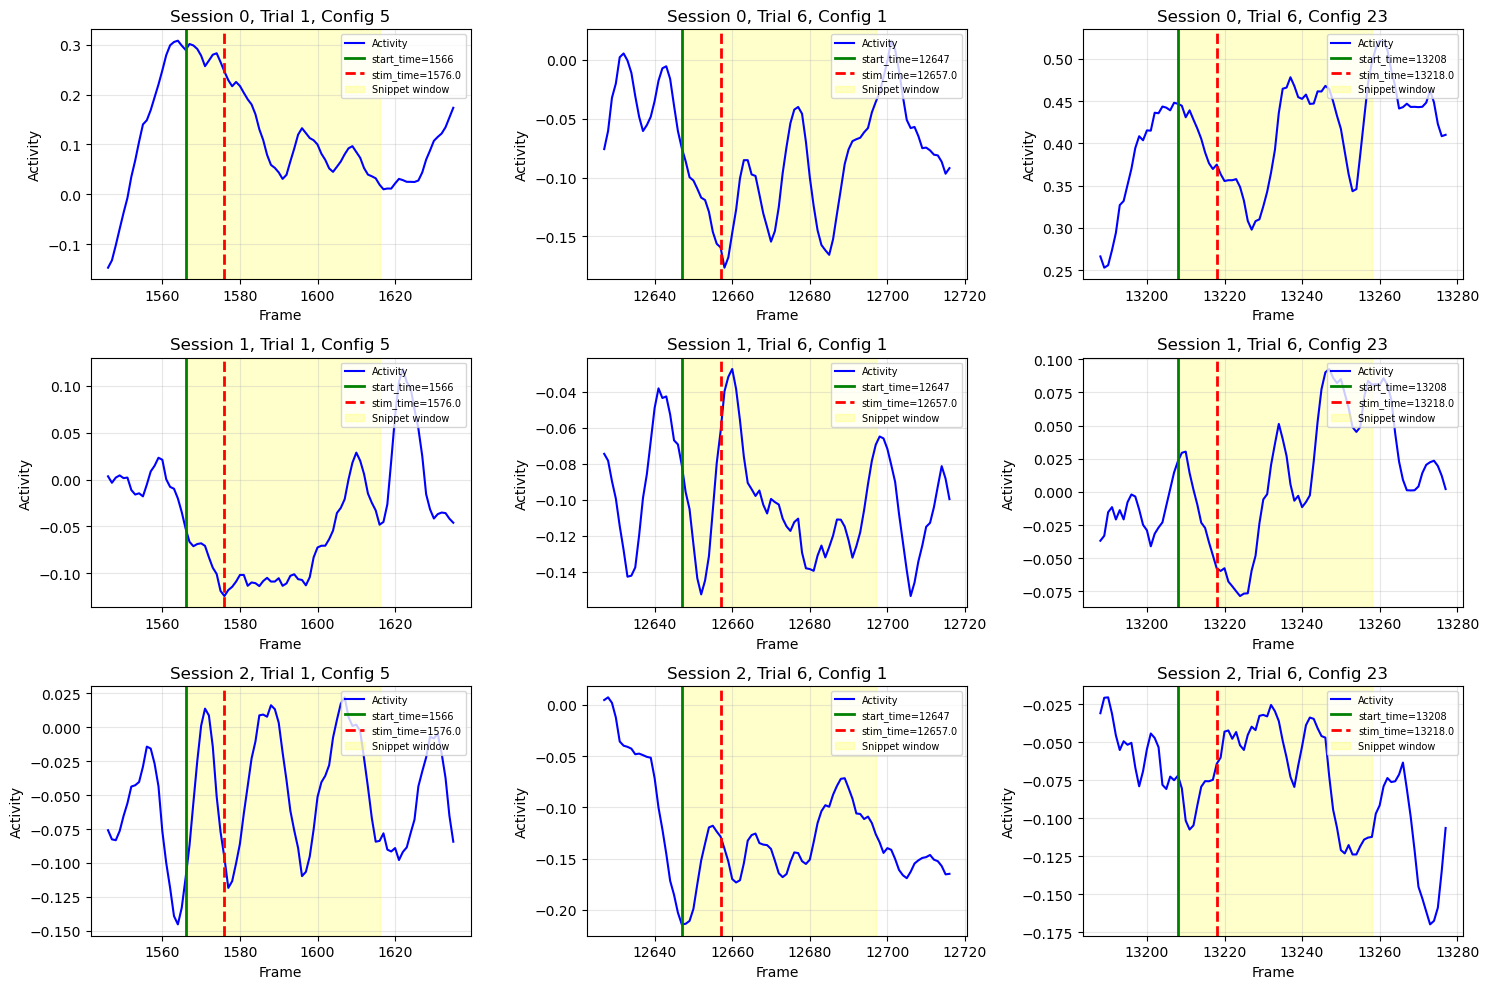

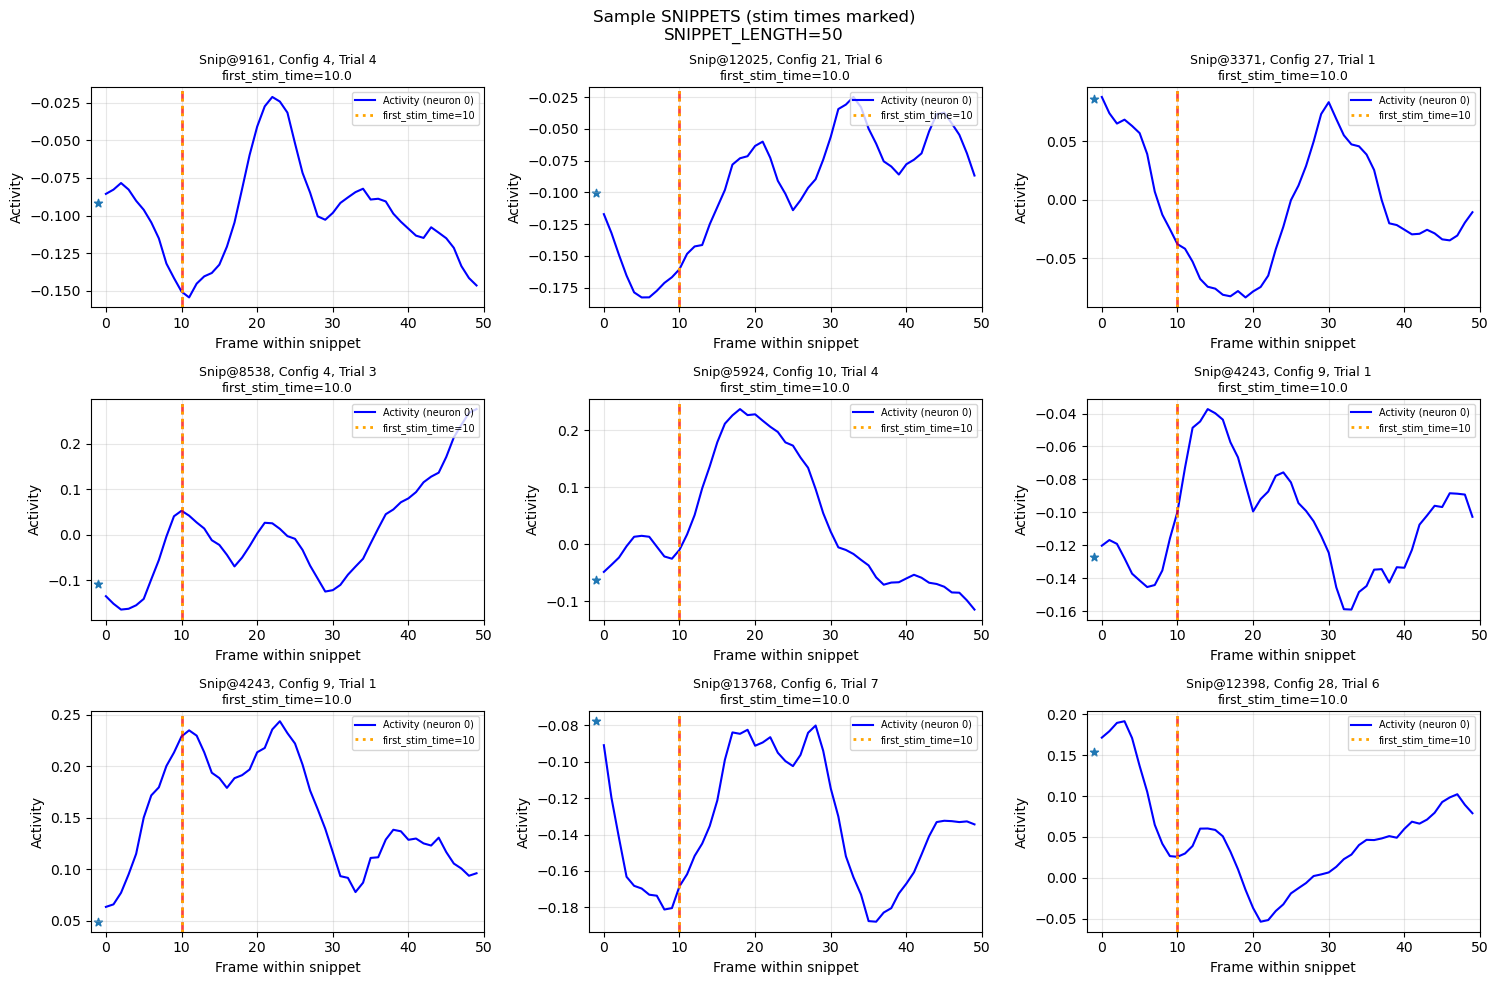

In [27]:
from viz import show_trials_snippets_sample

# Print summary for debugging
print("\n=== Trial vs Snippet Alignment Summary ===")
print(f"STIM_DELAY = {STIM_DELAY} (frames after trial start when stim occurs)")
print(f"START_OFFSET = {START_OFFSET} (snippet starts this many frames before stim)")
print(f"\nExpected: stim_time = start_time + STIM_DELAY")
print(f"Expected: snippet_start = stim_time - START_OFFSET (when stim_at_t0=True)")
print(f"\nIn snippets with stim_at_t0=True, first_stim_time should be ~0")
print(f"\nTest snippets: {len(test_df)}, unique trials in test: {sorted(test_df['first_trial'].dropna().unique())}")
show_trials_snippets_sample(trials_df, train_df, dfof, SNIPPET_LENGTH, seed=SEED, savepath=new_dir_path)

In [28]:
# Pass target_indices to SeqDataset to select which neurons to predict
# Initial conditions use all FILTER_NEURONS, predictions use only TARGET_NEURONS
# This will be replaced when cross validating; here for visualization purposes
train_ds = SeqDataset(df=train_df, target_indices=target_indices)
val_ds = SeqDataset(df=val_df, target_indices=target_indices)
test_ds = SeqDataset(df=test_df, target_indices=target_indices)



# --- prepare datasets using DataFrame-based SeqDataset ---
batch_size = 4
logging.info(f'Batch size: {batch_size}')


train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count() - 1, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, pin_memory=True)

logging.info("Dataset sizes -> train: %d, val: %d, test: %d",
             len(train_ds), len(val_ds), len(test_ds))
logging.info(f"Target neurons: {TARGET_NEURONS} (indices: {target_indices})")


# --- model, loss, optimizer ---
# Get dimensions from the dataset
sample_stim, _ = train_ds[0]
input_size = sample_stim[0].shape[1]  # n_electrodes
# Note: initial_conds uses all FILTER_NEURONS, but output_size matches TARGET_NEURONS
output_size = train_ds.Y.shape[2]     # n_target_neurons
initial_cond_size = train_ds.initial_conds.shape[1]  # n_filter_neurons

N_UNITS = 32  # hidden state size
LOSS_TYPE = "mse"  # Options: 'mse', 'mae', 'weighted_mae'
LR = 0.001
REGULARIZE = 0

# Create model: initial_cond_size uses all FILTER_NEURONS, output_size uses TARGET_NEURONS
model = RNNModel(input_size=input_size, units=N_UNITS, output_size=output_size, 
                 num_layers=NUM_LAYERS, initial_cond_size=initial_cond_size).to(device)
logging.info(f'Model architecture:\n{model}')
logging.info(f'Train input size: {input_size}')
logging.info(f'Initial condition size: {initial_cond_size} (FILTER_NEURONS)')
logging.info(f'Train output size: {output_size} (TARGET_NEURONS)')
logging.info(f'Hidden state size: {N_UNITS}')
logging.info(f'Number of GRU layers: {NUM_LAYERS}')


if LOSS_TYPE == 'mae':
    criterion = nn.MSELoss()
elif LOSS_TYPE == 'mae':
    criterion = nn.L1Loss()
elif LOSS_TYPE == 'weighted_mae':
    from modules import WeightedMAELoss
    # Weighted loss parameters
    STIM_WEIGHT = 5.0   # How much more to weight stim-adjacent frames
    STIM_WINDOW = 15    # Frames after stim to upweight (~0.5 sec at 30Hz)
    WEIGHT_DECAY = 'none'  # 'none', 'linear', or 'exp'
    criterion = WeightedMAELoss(stim_weight=STIM_WEIGHT, window=STIM_WINDOW, decay=WEIGHT_DECAY)
    logging.info(f'Using WeightedMAELoss: stim_weight={STIM_WEIGHT}, window={STIM_WINDOW}, decay={WEIGHT_DECAY}')
else:
    criterion = nn.MSELoss()

OPTIMIZER = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=REGULARIZE)
logging.info(f"Learning rate {LR}")
logging.info(f"Optimizer: {OPTIMIZER}")
logging.info(f"Loss type: {LOSS_TYPE}")
logging.info(f"Regularization coefficient: {REGULARIZE}")

# print (f'Example input: {example_input[0]}, \n\nactivity_initial: {example_input[1]}')


2026-01-16 11:47:32,002 INFO: Batch size: 4
2026-01-16 11:47:32,003 INFO: Dataset sizes -> train: 428, val: 76, test: 240
2026-01-16 11:47:32,004 INFO: Target neurons: {21, 22, 23, 26, 27, 31} (indices: [20, 21, 22, 25, 26, 30])
2026-01-16 11:47:32,009 INFO: Model architecture:
RNNModel(
  (initial_state_projection): Linear(in_features=110, out_features=32, bias=True)
  (rnn): GRU(10, 32, batch_first=True)
  (dense): Sequential(
    (0): Linear(in_features=32, out_features=6, bias=True)
  )
)
2026-01-16 11:47:32,010 INFO: Train input size: 10
2026-01-16 11:47:32,010 INFO: Initial condition size: 110 (FILTER_NEURONS)
2026-01-16 11:47:32,010 INFO: Train output size: 6 (TARGET_NEURONS)
2026-01-16 11:47:32,011 INFO: Hidden state size: 32
2026-01-16 11:47:32,011 INFO: Number of GRU layers: 1
2026-01-16 11:47:32,012 INFO: Learning rate 0.001
2026-01-16 11:47:32,012 INFO: Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_

## Visualize train/val/test split across sessions as timelines
###  Goal: verify that test snippets don't temporally overlap with train snippets

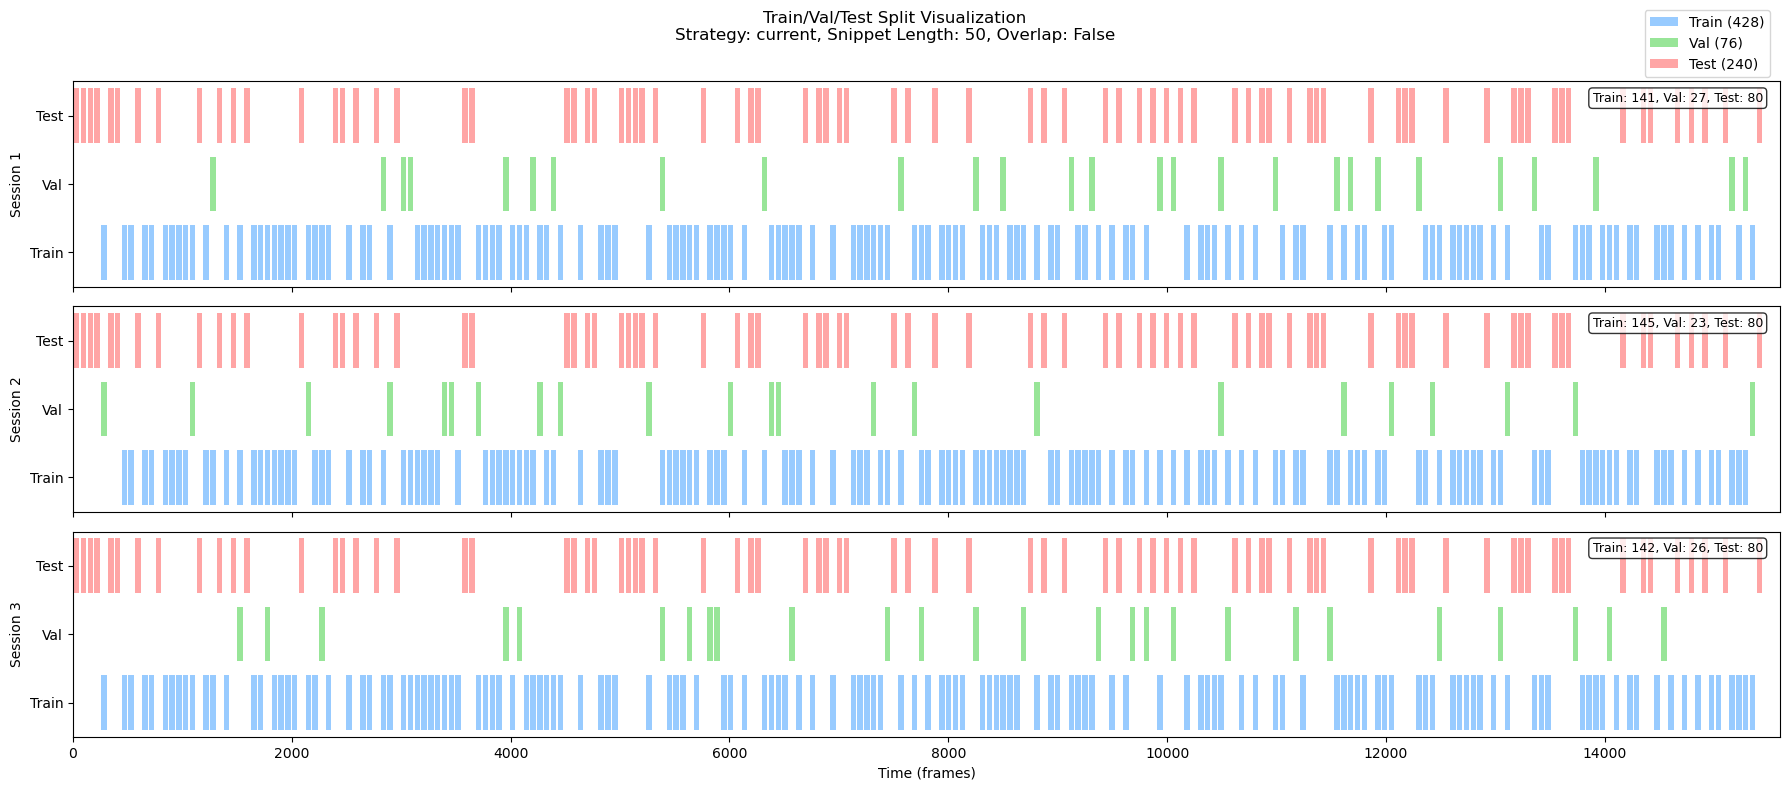


=== Overlap Analysis ===
Session 0: Train frames: 7050, Test frames: 4000, Overlap: 0 frames (0.0% of test)
Session 1: Train frames: 7250, Test frames: 4000, Overlap: 0 frames (0.0% of test)
Session 2: Train frames: 7100, Test frames: 4000, Overlap: 0 frames (0.0% of test)
Visualization saved to: rnn_training/20260116_114638/split_visualization.png


In [29]:
from viz import plot_split_visualization
    
# Call the visualization helper
plot_split_visualization(
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    dfof=dfof,
    snippet_length=SNIPPET_LENGTH,
    split_strategy=SPLIT_STRATEGY,
    snippet_overlap=SNIPPET_OVERLAP,
    holdout_trials=HOLDOUT_TRIALS if 'HOLDOUT_TRIALS' in globals() else [],
    trials_df=trials_df,
    output_dir=new_dir_path,
    num_sessions=3,
    figure_size=(18, 8),
    bar_height=0.8,
    dpi=150,
 )

In [30]:
from tqdm.notebook import tqdm
import time
import torch
import logging

def train_with_progress(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    checkpoint_path,
    device,
    device_type,   # e.g. "cuda", "mps", "cpu"
    num_epochs,
    loss_type=None,
    use_amp=True,
    max_grad_norm=1.0,
    early_stop_patience=5,
    min_epochs_before_early_stop=5,
):
    """
    Training loop with:
      - tqdm epoch + batch progress
      - AMP (autocast + GradScaler) when supported
      - optional weighted loss: criterion(outputs, targets, inputs)
      - validation + best-checkpoint save
      - simple early stopping on 'patience' consecutive non-improvements
    """
    best_val_loss = float("inf")
    history = {"train_loss": [], "val_loss": []}

    # AMP support varies by device; GradScaler is meaningful on CUDA.
    amp_enabled = bool(use_amp) and (device_type in ("cuda",))
    scaler = torch.amp.GradScaler(enabled=amp_enabled)

    def compute_loss(outputs, targets, inputs):
        if loss_type == "weighted_mae":
            return criterion(outputs, targets, inputs)
        return criterion(outputs, targets)

    epoch_pbar = tqdm(range(1, num_epochs + 1), desc="Epochs", unit="ep")

    for epoch in epoch_pbar:
        t0 = time.perf_counter()

        # -------------------- train --------------------
        model.train()
        running_loss = 0.0
        n_train = 0

        for (inputs, activity_initial), targets in tqdm(
            train_loader, desc=f"Epoch {epoch} Train", leave=False, unit="batch"
        ):
            inputs = inputs.to(device, non_blocking=True)
            activity_initial = activity_initial.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                outputs = model((inputs, activity_initial))
                loss = compute_loss(outputs, targets, inputs)

            if amp_enabled:
                scaler.scale(loss).backward()
                # unscale before clipping so clip is in true scale
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
                optimizer.step()

            bs = inputs.size(0)
            running_loss += loss.item() * bs
            n_train += bs

        train_loss = running_loss / max(n_train, 1)
        history["train_loss"].append(train_loss)
        logging.info(f"Epoch {epoch} Train loss: {train_loss:.6f}")

        # -------------------- val --------------------
        model.eval()
        val_running = 0.0
        n_val = 0

        with torch.no_grad():
            for (inputs, activity_initial), targets in tqdm(
                val_loader, desc=f"Epoch {epoch} Val", leave=False, unit="batch"
            ):
                inputs = inputs.to(device, non_blocking=True)
                activity_initial = activity_initial.to(device, non_blocking=True)
                targets = targets.to(device, non_blocking=True)

                with torch.autocast(device_type=device_type, dtype=torch.float16, enabled=amp_enabled):
                    outputs = model((inputs, activity_initial))
                    vloss = compute_loss(outputs, targets, inputs)

                bs = inputs.size(0)
                val_running += vloss.item() * bs
                n_val += bs

        val_loss = val_running / max(n_val, 1)
        history["val_loss"].append(val_loss)
        logging.info(f"Epoch {epoch} Validation loss: {val_loss:.6f}")

        # checkpoint best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), checkpoint_path)
            logging.info(f"Saved best model (val={best_val_loss:.6f}) -> {checkpoint_path}")

        # early stopping: no improvement for `patience` consecutive epochs
        if epoch > min_epochs_before_early_stop and len(history["val_loss"]) >= (early_stop_patience + 1):
            recent = history["val_loss"][-(early_stop_patience + 1):]
            no_improve = all(recent[i] >= recent[i - 1] for i in range(1, len(recent)))
            if no_improve:
                logging.info(
                    f"Early stopping: val loss did not improve for {early_stop_patience} consecutive epochs."
                )
                epoch_time = time.perf_counter() - t0
                epoch_pbar.set_postfix(
                    {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
                )
                break

        epoch_time = time.perf_counter() - t0
        epoch_pbar.set_postfix(
            {"train": f"{train_loss:.6f}", "val": f"{val_loss:.6f}", "sec": f"{epoch_time:.2f}"}
        )

    return history, best_val_loss

use_amp = True

# history, best_val_loss = train_with_progress(
#     model=model,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     criterion=criterion,
#     optimizer=OPTIMIZER,  
#     checkpoint_path=checkpoint_filepath,
#     device=device,
#     device_type=device_type,   # "cuda" / "mps" / "cpu"
#     num_epochs=NUM_EPOCHS,
#     loss_type=LOSS_TYPE,
#     use_amp=use_amp,
# )


## Calculate test-error

In [31]:
import os
import copy
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import logging
import json

from utils import get_inputs_outputs_targets, get_model_error, create_split_dfs
from modules import RNNModel, SeqDataset

# ----- Hyperparameters (collected in dict for reproducibility) -----
CV_HPARAMS = {
    'split_strategy': SPLIT_STRATEGY,
    'snippet_length': SNIPPET_LENGTH,
    'snippet_overlap': SNIPPET_OVERLAP,
    'snippet_stride': SNIPPET_STRIDE,
    'val_size': VAL_SIZE,
    'seed': SEED,
    'batch_size': batch_size,
    'n_units': N_UNITS,
    'num_layers': NUM_LAYERS,
    'loss_type': LOSS_TYPE,
    'lr': LR,
    'regularize': REGULARIZE,
    'num_epochs': NUM_EPOCHS,
    'early_stop_patience': 5,
    'use_amp': use_amp,
}

logging.info(f"=== Cross-Validation Hyperparameters ===")
for k, v in CV_HPARAMS.items():
    logging.info(f"  {k}: {v}")

# ----- Determine fold elements based on split strategy -----
if CV_HPARAMS['split_strategy'] == 'trial':
    fold_elements = list(range(8))  # trials 0-7
    holdout_key = 'holdout_trials'
elif CV_HPARAMS['split_strategy'] == 'session':
    fold_elements = list(range(3))  # sessions 0-2
    holdout_key = 'holdout_sessions'
elif CV_HPARAMS['split_strategy'] == 'config':
    fold_elements = list(range(1, 32))  # configs 1-31
    holdout_key = 'holdout_configs'
elif CV_HPARAMS['split_strategy'] == 'electrode':
    fold_elements = list(range(10)) + [None]  # electrodes 0-9 + None (config 31)
    holdout_key = 'holdout_electrodes'
elif CV_HPARAMS['split_strategy'] == 'current':
    fold_elements = [0, 3, 4, 5]  # current levels (0 = no stim)
    holdout_key = 'holdout_currents'
else:
    raise ValueError(f"Cross-validation not supported for strategy: {CV_HPARAMS['split_strategy']}")

n_folds = len(fold_elements)
logging.info(f"Running {n_folds}-fold CV on '{CV_HPARAMS['split_strategy']}' with elements: {fold_elements}")

# ----- Cross-validation loop -----
cv_results = []
for fold_idx, holdout_element in enumerate(tqdm(fold_elements, desc="CV Folds")):
    logging.info(f"\n{'='*60}")
    logging.info(f"FOLD {fold_idx + 1}/{n_folds}: Holding out {CV_HPARAMS['split_strategy']}={holdout_element}")
    logging.info(f"{'='*60}")
    
    # Build holdout kwargs: only set the relevant holdout, others empty
    holdout_kwargs = {
        'holdout_sessions': [],
        'holdout_trials': [],
        'holdout_configs': [],
        'holdout_electrodes': [],
        'holdout_currents': [],
    }
    holdout_kwargs[holdout_key] = [holdout_element]
    
    # Create train/val/test splits for this fold
    fold_train_df, fold_val_df, fold_test_df = create_split_dfs(
        split_strategy=CV_HPARAMS['split_strategy'],
        valid_df=valid_df.copy(),
        trials_df=trials_df,
        sessions=sessions,
        snippet_length=CV_HPARAMS['snippet_length'],
        val_size=CV_HPARAMS['val_size'],
        seed=CV_HPARAMS['seed'],
        **holdout_kwargs
    )
    
    # Skip fold if test set is empty
    if len(fold_test_df) == 0:
        logging.warning(f"Fold {fold_idx + 1}: Empty test set for holdout={holdout_element}, skipping.")
        continue
    
    logging.info(f"Fold {fold_idx + 1} sizes: train={len(fold_train_df)}, val={len(fold_val_df)}, test={len(fold_test_df)}")
    
    # Create datasets and loaders
    fold_train_ds = SeqDataset(df=fold_train_df, target_indices=target_indices)
    fold_val_ds = SeqDataset(df=fold_val_df, target_indices=target_indices)
    fold_test_ds = SeqDataset(df=fold_test_df, target_indices=target_indices)
    
    fold_train_loader = DataLoader(fold_train_ds, batch_size=CV_HPARAMS['batch_size'], 
                                   shuffle=True, num_workers=max(1, os.cpu_count() - 1), pin_memory=True)
    fold_val_loader = DataLoader(fold_val_ds, batch_size=CV_HPARAMS['batch_size'], 
                                 shuffle=False, pin_memory=True)
    fold_test_loader = DataLoader(fold_test_ds, batch_size=CV_HPARAMS['batch_size'], 
                                  shuffle=False, pin_memory=True)
    
    # Initialize fresh model for this fold
    fold_model = RNNModel(
        input_size=input_size, 
        units=CV_HPARAMS['n_units'], 
        output_size=output_size,
        num_layers=CV_HPARAMS['num_layers'], 
        initial_cond_size=initial_cond_size
    ).to(device)
    
    # Loss and optimizer
    if CV_HPARAMS['loss_type'] == 'mae':
        fold_criterion = nn.L1Loss()
    elif CV_HPARAMS['loss_type'] == 'weighted_mae':
        from modules import WeightedMAELoss
        fold_criterion = WeightedMAELoss(stim_weight=5.0, window=15, decay='none')
    else:
        fold_criterion = nn.MSELoss()
    
    fold_optimizer = torch.optim.Adam(fold_model.parameters(), lr=CV_HPARAMS['lr'], 
                                       weight_decay=CV_HPARAMS['regularize'])
    
    # Checkpoint path for this fold
    fold_checkpoint = os.path.join(new_dir_path, f"cv_fold_{fold_idx}_best.pth")
    
    # Train this fold (using the existing train_with_progress function)
    fold_history, fold_best_val = train_with_progress(
        model=fold_model,
        train_loader=fold_train_loader,
        val_loader=fold_val_loader,
        criterion=fold_criterion,
        optimizer=fold_optimizer,
        checkpoint_path=fold_checkpoint,
        device=device,
        device_type=device_type,
        num_epochs=CV_HPARAMS['num_epochs'],
        loss_type=CV_HPARAMS['loss_type'],
        use_amp=CV_HPARAMS['use_amp'],
        early_stop_patience=CV_HPARAMS['early_stop_patience'],
    )
    
    # Load best model and evaluate on test
    fold_model.load_state_dict(torch.load(fold_checkpoint, map_location=device))
    fold_model.eval()


    # Get fold-level test loss
    fold_test_loss, test_outputs = get_model_error(fold_model, fold_test_loader, fold_criterion, device, CV_HPARAMS['loss_type'])
    logging.info(f"Fold {fold_idx + 1} | Holdout={holdout_element} | Best Val={fold_best_val:.6f} | Test={fold_test_loss:.6f}")
    
    cv_results.append({
        'fold': fold_idx + 1,
        'holdout_element': holdout_element,
        'train_size': len(fold_train_df),
        'val_size': len(fold_val_df),
        'test_size': len(fold_test_df),
        'best_val_loss': fold_best_val,
        'test_loss': fold_test_loss,
        'history': fold_history,
        'test_outputs': test_outputs,
    })

# ----- Aggregate and report CV results -----
print("\n" + "="*70)
print(f"CROSS-VALIDATION RESULTS ({CV_HPARAMS['split_strategy']} strategy, {len(cv_results)} folds)")
print("="*70)

test_losses = [r['test_loss'] for r in cv_results]
val_losses = [r['best_val_loss'] for r in cv_results]

for r in cv_results:
    print(f"  Fold {r['fold']:2d} | Holdout={str(r['holdout_element']):>4s} | "
          f"Val={r['best_val_loss']:.6f} | Test={r['test_loss']:.6f} | "
          f"n_test={r['test_size']}")

print("-"*70)
cv_mean_test = np.mean(test_losses)
cv_std_test = np.std(test_losses)
cv_mean_val = np.mean(val_losses)
cv_std_val = np.std(val_losses)

print(f"  MEAN Test Loss: {cv_mean_test:.6f} ± {cv_std_test:.6f}")
print(f"  MEAN Val Loss:  {cv_mean_val:.6f} ± {cv_std_val:.6f}")
print("="*70)

logging.info(f"CV Complete: Mean Test Loss = {cv_mean_test:.6f} ± {cv_std_test:.6f}")

# Save CV results summary
cv_summary = {
    'hparams': CV_HPARAMS,
    'fold_results': [{k: v for k, v in r.items() if k != 'history'} for r in cv_results],
    'mean_test_loss': cv_mean_test,
    'std_test_loss': cv_std_test,
    'mean_val_loss': cv_mean_val,
    'std_val_loss': cv_std_val,
}
cv_summary_path = os.path.join(new_dir_path, 'cv_summary.json')
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"CV summary saved to {cv_summary_path}")

2026-01-16 11:48:26,585 INFO: === Cross-Validation Hyperparameters ===
2026-01-16 11:48:26,592 INFO:   split_strategy: current
2026-01-16 11:48:26,593 INFO:   snippet_length: 50
2026-01-16 11:48:26,593 INFO:   snippet_overlap: False
2026-01-16 11:48:26,594 INFO:   snippet_stride: 1
2026-01-16 11:48:26,594 INFO:   val_size: 0.15
2026-01-16 11:48:26,594 INFO:   seed: 42
2026-01-16 11:48:26,595 INFO:   batch_size: 4
2026-01-16 11:48:26,595 INFO:   n_units: 32
2026-01-16 11:48:26,595 INFO:   num_layers: 1
2026-01-16 11:48:26,595 INFO:   loss_type: mse
2026-01-16 11:48:26,596 INFO:   lr: 0.001
2026-01-16 11:48:26,596 INFO:   regularize: 0
2026-01-16 11:48:26,596 INFO:   num_epochs: 30
2026-01-16 11:48:26,597 INFO:   early_stop_patience: 5
2026-01-16 11:48:26,597 INFO:   use_amp: True
2026-01-16 11:48:26,598 INFO: Running 4-fold CV on 'current' with elements: [0, 3, 4, 5]


CV Folds:   0%|          | 0/4 [00:00<?, ?it/s]

2026-01-16 11:48:26,607 INFO: 
2026-01-16 11:48:26,607 INFO: FOLD 1/4: Holding out current=0
2026-01-16 11:48:26,608 INFO: ============================================================
2026-01-16 11:48:26,621 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-16 11:48:26,622 INFO: === Split Summary (current) ===
2026-01-16 11:48:26,622 INFO: Train: 612 samples (82.3%)
2026-01-16 11:48:26,623 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:48:26,623 INFO: Val: 108 samples (14.5%)
2026-01-16 11:48:26,623 INFO: Test: 24 samples (3.2%)
2026-01-16 11:48:26,624 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:48:26,627 INFO: Fold 1 sizes: train=612, val=108, test=24


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-16 11:48:32,076 INFO: Epoch 1 Train loss: 0.016822


Epoch 1 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:32,272 INFO: Epoch 1 Validation loss: 0.020598
2026-01-16 11:48:32,275 INFO: Saved best model (val=0.020598) -> rnn_training/20260116_114638/cv_fold_0_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:48:37,399 INFO: Epoch 2 Train loss: 0.014945


Epoch 2 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:37,634 INFO: Epoch 2 Validation loss: 0.015749
2026-01-16 11:48:37,639 INFO: Saved best model (val=0.015749) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 3 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:48:42,708 INFO: Epoch 3 Train loss: 0.011960


Epoch 3 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:42,938 INFO: Epoch 3 Validation loss: 0.014504
2026-01-16 11:48:42,942 INFO: Saved best model (val=0.014504) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 4 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:48:47,954 INFO: Epoch 4 Train loss: 0.010861


Epoch 4 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:48,179 INFO: Epoch 4 Validation loss: 0.014095
2026-01-16 11:48:48,182 INFO: Saved best model (val=0.014095) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 5 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:48:53,172 INFO: Epoch 5 Train loss: 0.010372


Epoch 5 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:53,406 INFO: Epoch 5 Validation loss: 0.013055
2026-01-16 11:48:53,410 INFO: Saved best model (val=0.013055) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 6 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:48:58,384 INFO: Epoch 6 Train loss: 0.009803


Epoch 6 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:48:58,607 INFO: Epoch 6 Validation loss: 0.012637
2026-01-16 11:48:58,611 INFO: Saved best model (val=0.012637) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 7 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:03,902 INFO: Epoch 7 Train loss: 0.009260


Epoch 7 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:04,140 INFO: Epoch 7 Validation loss: 0.012062
2026-01-16 11:49:04,144 INFO: Saved best model (val=0.012062) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 8 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:09,549 INFO: Epoch 8 Train loss: 0.008893


Epoch 8 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:09,779 INFO: Epoch 8 Validation loss: 0.012447


Epoch 9 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:14,924 INFO: Epoch 9 Train loss: 0.008580


Epoch 9 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:15,164 INFO: Epoch 9 Validation loss: 0.011539
2026-01-16 11:49:15,167 INFO: Saved best model (val=0.011539) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 10 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:20,341 INFO: Epoch 10 Train loss: 0.008321


Epoch 10 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:20,569 INFO: Epoch 10 Validation loss: 0.011525
2026-01-16 11:49:20,572 INFO: Saved best model (val=0.011525) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 11 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:26,322 INFO: Epoch 11 Train loss: 0.008094


Epoch 11 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:26,556 INFO: Epoch 11 Validation loss: 0.011414
2026-01-16 11:49:26,560 INFO: Saved best model (val=0.011414) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 12 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:32,143 INFO: Epoch 12 Train loss: 0.007842


Epoch 12 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:32,377 INFO: Epoch 12 Validation loss: 0.011018
2026-01-16 11:49:32,380 INFO: Saved best model (val=0.011018) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 13 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:38,040 INFO: Epoch 13 Train loss: 0.007655


Epoch 13 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:38,292 INFO: Epoch 13 Validation loss: 0.010745
2026-01-16 11:49:38,297 INFO: Saved best model (val=0.010745) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 14 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:44,368 INFO: Epoch 14 Train loss: 0.007518


Epoch 14 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:44,630 INFO: Epoch 14 Validation loss: 0.011003


Epoch 15 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:51,233 INFO: Epoch 15 Train loss: 0.007383


Epoch 15 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:51,472 INFO: Epoch 15 Validation loss: 0.011153


Epoch 16 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:49:58,515 INFO: Epoch 16 Train loss: 0.007245


Epoch 16 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:49:58,763 INFO: Epoch 16 Validation loss: 0.011043


Epoch 17 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:06,153 INFO: Epoch 17 Train loss: 0.007207


Epoch 17 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:06,419 INFO: Epoch 17 Validation loss: 0.011266


Epoch 18 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:14,385 INFO: Epoch 18 Train loss: 0.007147


Epoch 18 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:14,693 INFO: Epoch 18 Validation loss: 0.010705
2026-01-16 11:50:14,698 INFO: Saved best model (val=0.010705) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 19 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:23,701 INFO: Epoch 19 Train loss: 0.006945


Epoch 19 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:24,023 INFO: Epoch 19 Validation loss: 0.010692
2026-01-16 11:50:24,028 INFO: Saved best model (val=0.010692) -> rnn_training/20260116_114638/cv_fold_0_best.pth


Epoch 20 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:35,640 INFO: Epoch 20 Train loss: 0.006899


Epoch 20 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:35,987 INFO: Epoch 20 Validation loss: 0.011331


Epoch 21 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:45,492 INFO: Epoch 21 Train loss: 0.006950


Epoch 21 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:45,866 INFO: Epoch 21 Validation loss: 0.010883


Epoch 22 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:50:53,305 INFO: Epoch 22 Train loss: 0.006782


Epoch 22 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:50:53,557 INFO: Epoch 22 Validation loss: 0.010817


Epoch 23 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:01,290 INFO: Epoch 23 Train loss: 0.006676


Epoch 23 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:01,606 INFO: Epoch 23 Validation loss: 0.011067


Epoch 24 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:12,590 INFO: Epoch 24 Train loss: 0.006613


Epoch 24 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:12,988 INFO: Epoch 24 Validation loss: 0.011530


Epoch 25 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:23,695 INFO: Epoch 25 Train loss: 0.006663


Epoch 25 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:24,031 INFO: Epoch 25 Validation loss: 0.011028


Epoch 26 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:32,436 INFO: Epoch 26 Train loss: 0.006501


Epoch 26 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:32,676 INFO: Epoch 26 Validation loss: 0.011331


Epoch 27 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:40,070 INFO: Epoch 27 Train loss: 0.006424


Epoch 27 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:40,329 INFO: Epoch 27 Validation loss: 0.010949


Epoch 28 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:48,882 INFO: Epoch 28 Train loss: 0.006399


Epoch 28 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:49,165 INFO: Epoch 28 Validation loss: 0.011272


Epoch 29 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:51:58,408 INFO: Epoch 29 Train loss: 0.006276


Epoch 29 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:51:58,769 INFO: Epoch 29 Validation loss: 0.011214


Epoch 30 Train:   0%|          | 0/153 [00:00<?, ?batch/s]

2026-01-16 11:52:07,813 INFO: Epoch 30 Train loss: 0.006231


Epoch 30 Val:   0%|          | 0/27 [00:00<?, ?batch/s]

2026-01-16 11:52:08,146 INFO: Epoch 30 Validation loss: 0.011666
2026-01-16 11:52:08,234 INFO: Fold 1 | Holdout=0 | Best Val=0.010692 | Test=0.008493
2026-01-16 11:52:08,236 INFO: 
2026-01-16 11:52:08,236 INFO: FOLD 2/4: Holding out current=3
2026-01-16 11:52:08,238 INFO: ============================================================
2026-01-16 11:52:08,271 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-16 11:52:08,275 INFO: === Split Summary (current) ===
2026-01-16 11:52:08,276 INFO: Train: 428 samples (57.5%)
2026-01-16 11:52:08,276 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:52:08,277 INFO: Val: 76 samples (10.2%)
2026-01-16 11:52:08,278 INFO: Test: 240 samples (32.3%)
2026-01-16 11:52:08,279 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:52:08,279 INFO: Fold 2 sizes: train=428, val=76, test=240


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-16 11:52:16,174 INFO: Epoch 1 Train loss: 0.021537


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-16 11:52:16,435 INFO: Epoch 1 Validation loss: 0.013897
2026-01-16 11:52:16,440 INFO: Saved best model (val=0.013897) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 2 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:52:24,263 INFO: Epoch 2 Train loss: 0.017836


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:52:24,510 INFO: Epoch 2 Validation loss: 0.012596
2026-01-16 11:52:24,516 INFO: Saved best model (val=0.012596) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 3 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:52:32,651 INFO: Epoch 3 Train loss: 0.014486


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:52:32,894 INFO: Epoch 3 Validation loss: 0.010970
2026-01-16 11:52:32,899 INFO: Saved best model (val=0.010970) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 4 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:52:40,630 INFO: Epoch 4 Train loss: 0.012667


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:52:40,860 INFO: Epoch 4 Validation loss: 0.010590
2026-01-16 11:52:40,866 INFO: Saved best model (val=0.010590) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 5 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:52:48,456 INFO: Epoch 5 Train loss: 0.011727


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:52:48,694 INFO: Epoch 5 Validation loss: 0.011536


Epoch 6 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:52:55,965 INFO: Epoch 6 Train loss: 0.011248


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:52:56,137 INFO: Epoch 6 Validation loss: 0.010005
2026-01-16 11:52:56,143 INFO: Saved best model (val=0.010005) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 7 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:02,174 INFO: Epoch 7 Train loss: 0.010663


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:02,402 INFO: Epoch 7 Validation loss: 0.010763


Epoch 8 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:08,742 INFO: Epoch 8 Train loss: 0.010249


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:08,967 INFO: Epoch 8 Validation loss: 0.009675
2026-01-16 11:53:08,971 INFO: Saved best model (val=0.009675) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 9 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:15,149 INFO: Epoch 9 Train loss: 0.009744


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:15,357 INFO: Epoch 9 Validation loss: 0.009251
2026-01-16 11:53:15,361 INFO: Saved best model (val=0.009251) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 10 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:21,491 INFO: Epoch 10 Train loss: 0.009383


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:21,708 INFO: Epoch 10 Validation loss: 0.009573


Epoch 11 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:27,782 INFO: Epoch 11 Train loss: 0.009001


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:27,960 INFO: Epoch 11 Validation loss: 0.009353


Epoch 12 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:33,965 INFO: Epoch 12 Train loss: 0.008797


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:34,171 INFO: Epoch 12 Validation loss: 0.009449


Epoch 13 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:40,276 INFO: Epoch 13 Train loss: 0.008653


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:40,502 INFO: Epoch 13 Validation loss: 0.009129
2026-01-16 11:53:40,506 INFO: Saved best model (val=0.009129) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 14 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:46,898 INFO: Epoch 14 Train loss: 0.008408


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:47,116 INFO: Epoch 14 Validation loss: 0.009002
2026-01-16 11:53:47,119 INFO: Saved best model (val=0.009002) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 15 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:53,505 INFO: Epoch 15 Train loss: 0.008218


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:53:53,722 INFO: Epoch 15 Validation loss: 0.009747


Epoch 16 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:53:59,977 INFO: Epoch 16 Train loss: 0.008027


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:00,185 INFO: Epoch 16 Validation loss: 0.008910
2026-01-16 11:54:00,188 INFO: Saved best model (val=0.008910) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 17 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:06,445 INFO: Epoch 17 Train loss: 0.007918


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:06,667 INFO: Epoch 17 Validation loss: 0.009018


Epoch 18 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:12,761 INFO: Epoch 18 Train loss: 0.007750


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:12,975 INFO: Epoch 18 Validation loss: 0.008697
2026-01-16 11:54:12,979 INFO: Saved best model (val=0.008697) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 19 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:18,704 INFO: Epoch 19 Train loss: 0.007540


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:18,907 INFO: Epoch 19 Validation loss: 0.008985


Epoch 20 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:24,596 INFO: Epoch 20 Train loss: 0.007421


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:24,800 INFO: Epoch 20 Validation loss: 0.008938


Epoch 21 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:30,559 INFO: Epoch 21 Train loss: 0.007305


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:30,767 INFO: Epoch 21 Validation loss: 0.008807


Epoch 22 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:36,466 INFO: Epoch 22 Train loss: 0.007268


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:36,693 INFO: Epoch 22 Validation loss: 0.009262


Epoch 23 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:42,415 INFO: Epoch 23 Train loss: 0.007072


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:42,614 INFO: Epoch 23 Validation loss: 0.008699


Epoch 24 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:48,400 INFO: Epoch 24 Train loss: 0.007081


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:48,591 INFO: Epoch 24 Validation loss: 0.009230


Epoch 25 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:54,159 INFO: Epoch 25 Train loss: 0.006996


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:54:54,345 INFO: Epoch 25 Validation loss: 0.009097


Epoch 26 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:54:59,823 INFO: Epoch 26 Train loss: 0.006957


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:00,026 INFO: Epoch 26 Validation loss: 0.008658
2026-01-16 11:55:00,030 INFO: Saved best model (val=0.008658) -> rnn_training/20260116_114638/cv_fold_1_best.pth


Epoch 27 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:05,452 INFO: Epoch 27 Train loss: 0.006828


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:05,648 INFO: Epoch 27 Validation loss: 0.008922


Epoch 28 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:11,034 INFO: Epoch 28 Train loss: 0.006755


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:11,223 INFO: Epoch 28 Validation loss: 0.009006


Epoch 29 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:16,506 INFO: Epoch 29 Train loss: 0.006707


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:16,694 INFO: Epoch 29 Validation loss: 0.008908


Epoch 30 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:22,013 INFO: Epoch 30 Train loss: 0.006564


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:22,196 INFO: Epoch 30 Validation loss: 0.009127
2026-01-16 11:55:22,711 INFO: Fold 2 | Holdout=3 | Best Val=0.008658 | Test=0.009193
2026-01-16 11:55:22,712 INFO: 
2026-01-16 11:55:22,712 INFO: FOLD 3/4: Holding out current=4
2026-01-16 11:55:22,712 INFO: ============================================================
2026-01-16 11:55:22,731 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-16 11:55:22,733 INFO: === Split Summary (current) ===
2026-01-16 11:55:22,733 INFO: Train: 428 samples (57.5%)
2026-01-16 11:55:22,734 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:55:22,734 INFO: Val: 76 samples (10.2%)
2026-01-16 11:55:22,734 INFO: Test: 240 samples (32.3%)
2026-01-16 11:55:22,735 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:55:22,735 INFO: Fold 3 sizes: train=428, val=76, test=240


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-16 11:55:28,021 INFO: Epoch 1 Train loss: 0.019353


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:28,197 INFO: Epoch 1 Validation loss: 0.012157
2026-01-16 11:55:28,200 INFO: Saved best model (val=0.012157) -> rnn_training/20260116_114638/cv_fold_2_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:33,453 INFO: Epoch 2 Train loss: 0.016269


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:33,647 INFO: Epoch 2 Validation loss: 0.011708
2026-01-16 11:55:33,650 INFO: Saved best model (val=0.011708) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 3 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:39,071 INFO: Epoch 3 Train loss: 0.013712


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:39,269 INFO: Epoch 3 Validation loss: 0.010405
2026-01-16 11:55:39,272 INFO: Saved best model (val=0.010405) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 4 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:44,555 INFO: Epoch 4 Train loss: 0.011827


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:44,738 INFO: Epoch 4 Validation loss: 0.009905
2026-01-16 11:55:44,741 INFO: Saved best model (val=0.009905) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 5 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:50,038 INFO: Epoch 5 Train loss: 0.011243


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:50,231 INFO: Epoch 5 Validation loss: 0.010197


Epoch 6 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:55:55,779 INFO: Epoch 6 Train loss: 0.010785


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:55:55,982 INFO: Epoch 6 Validation loss: 0.009558
2026-01-16 11:55:55,985 INFO: Saved best model (val=0.009558) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 7 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:01,547 INFO: Epoch 7 Train loss: 0.010243


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:01,746 INFO: Epoch 7 Validation loss: 0.009261
2026-01-16 11:56:01,749 INFO: Saved best model (val=0.009261) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 8 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:07,847 INFO: Epoch 8 Train loss: 0.009818


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:08,048 INFO: Epoch 8 Validation loss: 0.009223
2026-01-16 11:56:08,051 INFO: Saved best model (val=0.009223) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 9 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:13,875 INFO: Epoch 9 Train loss: 0.009392


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:14,071 INFO: Epoch 9 Validation loss: 0.009167
2026-01-16 11:56:14,074 INFO: Saved best model (val=0.009167) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 10 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:19,548 INFO: Epoch 10 Train loss: 0.009199


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:19,731 INFO: Epoch 10 Validation loss: 0.009172


Epoch 11 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:25,203 INFO: Epoch 11 Train loss: 0.008884


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:25,398 INFO: Epoch 11 Validation loss: 0.009307


Epoch 12 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:30,954 INFO: Epoch 12 Train loss: 0.008737


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:31,153 INFO: Epoch 12 Validation loss: 0.009385


Epoch 13 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:36,570 INFO: Epoch 13 Train loss: 0.008537


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:36,768 INFO: Epoch 13 Validation loss: 0.009000
2026-01-16 11:56:36,771 INFO: Saved best model (val=0.009000) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 14 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:42,151 INFO: Epoch 14 Train loss: 0.008376


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:42,347 INFO: Epoch 14 Validation loss: 0.008800
2026-01-16 11:56:42,351 INFO: Saved best model (val=0.008800) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 15 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:47,708 INFO: Epoch 15 Train loss: 0.008196


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:47,914 INFO: Epoch 15 Validation loss: 0.008833


Epoch 16 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:53,320 INFO: Epoch 16 Train loss: 0.008025


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:53,520 INFO: Epoch 16 Validation loss: 0.008773
2026-01-16 11:56:53,523 INFO: Saved best model (val=0.008773) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 17 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:56:58,961 INFO: Epoch 17 Train loss: 0.007988


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:56:59,150 INFO: Epoch 17 Validation loss: 0.009032


Epoch 18 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:04,596 INFO: Epoch 18 Train loss: 0.007842


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:04,792 INFO: Epoch 18 Validation loss: 0.008961


Epoch 19 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:10,306 INFO: Epoch 19 Train loss: 0.007684


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:10,501 INFO: Epoch 19 Validation loss: 0.008752
2026-01-16 11:57:10,504 INFO: Saved best model (val=0.008752) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 20 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:16,083 INFO: Epoch 20 Train loss: 0.007605


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:16,280 INFO: Epoch 20 Validation loss: 0.009424


Epoch 21 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:21,825 INFO: Epoch 21 Train loss: 0.007564


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:22,025 INFO: Epoch 21 Validation loss: 0.009124


Epoch 22 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:27,526 INFO: Epoch 22 Train loss: 0.007419


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:27,726 INFO: Epoch 22 Validation loss: 0.008863


Epoch 23 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:33,224 INFO: Epoch 23 Train loss: 0.007387


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:33,424 INFO: Epoch 23 Validation loss: 0.008943


Epoch 24 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:38,866 INFO: Epoch 24 Train loss: 0.007335


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:39,027 INFO: Epoch 24 Validation loss: 0.008629
2026-01-16 11:57:39,030 INFO: Saved best model (val=0.008629) -> rnn_training/20260116_114638/cv_fold_2_best.pth


Epoch 25 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:44,468 INFO: Epoch 25 Train loss: 0.007203


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:44,670 INFO: Epoch 25 Validation loss: 0.008776


Epoch 26 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:50,111 INFO: Epoch 26 Train loss: 0.007026


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:50,326 INFO: Epoch 26 Validation loss: 0.009421


Epoch 27 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:57:55,762 INFO: Epoch 27 Train loss: 0.007355


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:57:55,955 INFO: Epoch 27 Validation loss: 0.008943


Epoch 28 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:01,391 INFO: Epoch 28 Train loss: 0.006965


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:01,587 INFO: Epoch 28 Validation loss: 0.008782


Epoch 29 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:07,019 INFO: Epoch 29 Train loss: 0.006824


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:07,214 INFO: Epoch 29 Validation loss: 0.008814


Epoch 30 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:12,613 INFO: Epoch 30 Train loss: 0.006844


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:12,802 INFO: Epoch 30 Validation loss: 0.008930
2026-01-16 11:58:13,308 INFO: Fold 3 | Holdout=4 | Best Val=0.008629 | Test=0.009250
2026-01-16 11:58:13,308 INFO: 
2026-01-16 11:58:13,309 INFO: FOLD 4/4: Holding out current=5
2026-01-16 11:58:13,309 INFO: ============================================================
2026-01-16 11:58:13,324 INFO: Removing 0 additional snippets that overlap with test frames
2026-01-16 11:58:13,326 INFO: === Split Summary (current) ===
2026-01-16 11:58:13,327 INFO: Train: 428 samples (57.5%)
2026-01-16 11:58:13,327 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:58:13,327 INFO: Val: 76 samples (10.2%)
2026-01-16 11:58:13,328 INFO: Test: 240 samples (32.3%)
2026-01-16 11:58:13,328 INFO:   Sessions: [np.int64(0), np.int64(1), np.int64(2)]
2026-01-16 11:58:13,328 INFO: Fold 4 sizes: train=428, val=76, test=240


Epochs:   0%|          | 0/30 [00:00<?, ?ep/s]

Epoch 1 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:1117: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


2026-01-16 11:58:18,857 INFO: Epoch 1 Train loss: 0.017335


Epoch 1 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:19,055 INFO: Epoch 1 Validation loss: 0.012007
2026-01-16 11:58:19,058 INFO: Saved best model (val=0.012007) -> rnn_training/20260116_114638/cv_fold_3_best.pth


/Users/shubhom/anaconda3/envs/3_11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:774: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  super().__init__(loader)


Epoch 2 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:24,557 INFO: Epoch 2 Train loss: 0.013718


Epoch 2 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:24,748 INFO: Epoch 2 Validation loss: 0.010094
2026-01-16 11:58:24,752 INFO: Saved best model (val=0.010094) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 3 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:30,259 INFO: Epoch 3 Train loss: 0.011407


Epoch 3 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:30,455 INFO: Epoch 3 Validation loss: 0.009374
2026-01-16 11:58:30,458 INFO: Saved best model (val=0.009374) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 4 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:36,032 INFO: Epoch 4 Train loss: 0.010800


Epoch 4 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:36,228 INFO: Epoch 4 Validation loss: 0.009435


Epoch 5 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:41,632 INFO: Epoch 5 Train loss: 0.010291


Epoch 5 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:41,832 INFO: Epoch 5 Validation loss: 0.009188
2026-01-16 11:58:41,836 INFO: Saved best model (val=0.009188) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 6 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:47,306 INFO: Epoch 6 Train loss: 0.010154


Epoch 6 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:47,510 INFO: Epoch 6 Validation loss: 0.008901
2026-01-16 11:58:47,514 INFO: Saved best model (val=0.008901) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 7 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:53,024 INFO: Epoch 7 Train loss: 0.009761


Epoch 7 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:53,220 INFO: Epoch 7 Validation loss: 0.009712


Epoch 8 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:58:58,750 INFO: Epoch 8 Train loss: 0.009642


Epoch 8 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:58:58,949 INFO: Epoch 8 Validation loss: 0.008831
2026-01-16 11:58:58,953 INFO: Saved best model (val=0.008831) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 9 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:04,356 INFO: Epoch 9 Train loss: 0.009126


Epoch 9 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:04,552 INFO: Epoch 9 Validation loss: 0.008613
2026-01-16 11:59:04,556 INFO: Saved best model (val=0.008613) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 10 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:09,928 INFO: Epoch 10 Train loss: 0.008701


Epoch 10 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:10,125 INFO: Epoch 10 Validation loss: 0.008632


Epoch 11 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:15,583 INFO: Epoch 11 Train loss: 0.008254


Epoch 11 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:15,776 INFO: Epoch 11 Validation loss: 0.008511
2026-01-16 11:59:15,780 INFO: Saved best model (val=0.008511) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 12 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:21,297 INFO: Epoch 12 Train loss: 0.008105


Epoch 12 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:21,492 INFO: Epoch 12 Validation loss: 0.008665


Epoch 13 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:27,094 INFO: Epoch 13 Train loss: 0.007911


Epoch 13 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:27,294 INFO: Epoch 13 Validation loss: 0.008559


Epoch 14 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:32,852 INFO: Epoch 14 Train loss: 0.007819


Epoch 14 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:33,050 INFO: Epoch 14 Validation loss: 0.008708


Epoch 15 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:38,523 INFO: Epoch 15 Train loss: 0.007638


Epoch 15 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:38,716 INFO: Epoch 15 Validation loss: 0.008672


Epoch 16 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:44,201 INFO: Epoch 16 Train loss: 0.007448


Epoch 16 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:44,399 INFO: Epoch 16 Validation loss: 0.008587


Epoch 17 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:49,828 INFO: Epoch 17 Train loss: 0.007376


Epoch 17 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:50,030 INFO: Epoch 17 Validation loss: 0.008666


Epoch 18 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 11:59:55,498 INFO: Epoch 18 Train loss: 0.007220


Epoch 18 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 11:59:55,690 INFO: Epoch 18 Validation loss: 0.008564


Epoch 19 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:01,106 INFO: Epoch 19 Train loss: 0.007070


Epoch 19 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:01,291 INFO: Epoch 19 Validation loss: 0.008766


Epoch 20 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:06,773 INFO: Epoch 20 Train loss: 0.007004


Epoch 20 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:06,972 INFO: Epoch 20 Validation loss: 0.008363
2026-01-16 12:00:06,976 INFO: Saved best model (val=0.008363) -> rnn_training/20260116_114638/cv_fold_3_best.pth


Epoch 21 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:12,418 INFO: Epoch 21 Train loss: 0.006921


Epoch 21 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:12,643 INFO: Epoch 21 Validation loss: 0.008651


Epoch 22 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:18,184 INFO: Epoch 22 Train loss: 0.006805


Epoch 22 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:18,386 INFO: Epoch 22 Validation loss: 0.008838


Epoch 23 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:23,844 INFO: Epoch 23 Train loss: 0.006746


Epoch 23 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:24,060 INFO: Epoch 23 Validation loss: 0.008718


Epoch 24 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:29,561 INFO: Epoch 24 Train loss: 0.006718


Epoch 24 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:29,755 INFO: Epoch 24 Validation loss: 0.008646


Epoch 25 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:35,235 INFO: Epoch 25 Train loss: 0.006564


Epoch 25 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:35,456 INFO: Epoch 25 Validation loss: 0.008856


Epoch 26 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:40,947 INFO: Epoch 26 Train loss: 0.006544


Epoch 26 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:41,150 INFO: Epoch 26 Validation loss: 0.008708


Epoch 27 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:46,618 INFO: Epoch 27 Train loss: 0.006556


Epoch 27 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:46,842 INFO: Epoch 27 Validation loss: 0.008682


Epoch 28 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:52,513 INFO: Epoch 28 Train loss: 0.006409


Epoch 28 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:52,716 INFO: Epoch 28 Validation loss: 0.008944


Epoch 29 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:00:58,394 INFO: Epoch 29 Train loss: 0.006378


Epoch 29 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:00:58,593 INFO: Epoch 29 Validation loss: 0.008926


Epoch 30 Train:   0%|          | 0/107 [00:00<?, ?batch/s]

2026-01-16 12:01:04,276 INFO: Epoch 30 Train loss: 0.006246


Epoch 30 Val:   0%|          | 0/19 [00:00<?, ?batch/s]

2026-01-16 12:01:04,489 INFO: Epoch 30 Validation loss: 0.008757
2026-01-16 12:01:05,003 INFO: Fold 4 | Holdout=5 | Best Val=0.008363 | Test=0.011729

CROSS-VALIDATION RESULTS (current strategy, 4 folds)
  Fold  1 | Holdout=   0 | Val=0.010692 | Test=0.008493 | n_test=24
  Fold  2 | Holdout=   3 | Val=0.008658 | Test=0.009193 | n_test=240
  Fold  3 | Holdout=   4 | Val=0.008629 | Test=0.009250 | n_test=240
  Fold  4 | Holdout=   5 | Val=0.008363 | Test=0.011729 | n_test=240
----------------------------------------------------------------------
  MEAN Test Loss: 0.009666 ± 0.001228
  MEAN Val Loss:  0.009086 ± 0.000934
2026-01-16 12:01:05,004 INFO: CV Complete: Mean Test Loss = 0.009666 ± 0.001228
2026-01-16 12:01:05,009 INFO: CV summary saved to rnn_training/20260116_114638/cv_summary.json


2026-01-16 12:02:00,165 INFO: CV test loss bar plot saved to rnn_training/20260116_114638/cv_test_loss_bar.png


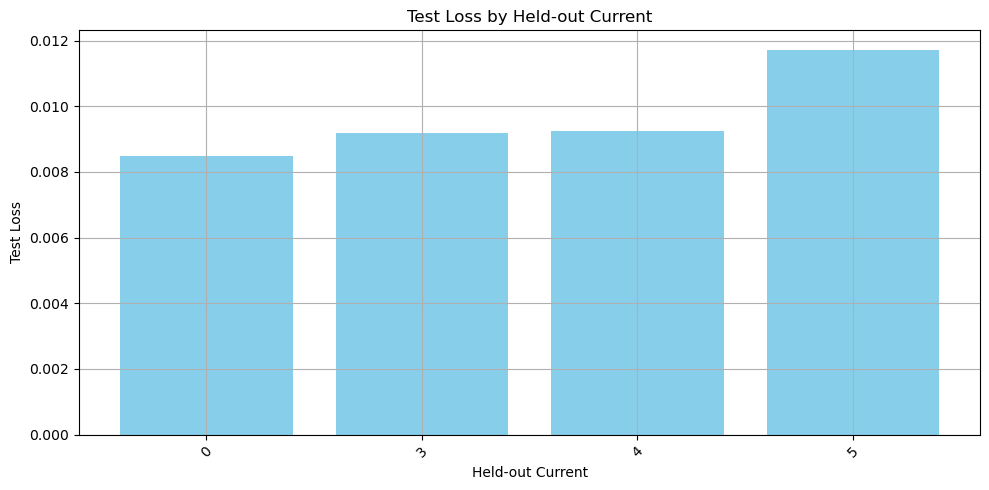

In [32]:
from viz import plot_cv_test_loss_bar
plot_cv_test_loss_bar(cv_results, SPLIT_STRATEGY, savepath=os.path.join(new_dir_path, 'cv_test_loss_bar.png'))




## Correlation plots of predicted vs. ground-truth snippets

In [33]:
# Compute z-score correlations for CV results
from viz import compute_cv_zscore_correlations

cv_results, overall_zscore_corr = compute_cv_zscore_correlations(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,cmodel = 
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    window_size=50,
    save_dir=os.path.join(new_dir_path, 'zscore_corr_cv'),
    save_plots=True,  # Set to True to save individual plots
)

# Update CV summary with z-score correlations
cv_summary['fold_results'] = [{
    k: v for k, v in r.items() 
    if k not in ['history', 'test_outputs', 'zscore_correlations']
} for r in cv_results]
cv_summary['overall_zscore_corr'] = overall_zscore_corr
cv_summary['fold_zscore_corrs'] = [r.get('mean_zscore_corr', np.nan) for r in cv_results]

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with z-score correlations saved to {cv_summary_path}")

SyntaxError: invalid syntax (1350225246.py, line 9)


80th percentile thresholds for target neurons:
  ROI 21: 0.0611 df/F
  ROI 22: 0.0731 df/F
  ROI 23: 0.0665 df/F
  ROI 26: 0.1150 df/F
  ROI 27: 0.0763 df/F
  ROI 31: 0.0715 df/F
2026-01-16 12:02:15,913 INFO: Computed 80th percentile thresholds for 110 ROIs
2026-01-16 12:02:15,913 INFO: Evaluating 6 ROIs: [21, 22, 23, 26, 27, 31]
2026-01-16 12:02:15,914 INFO: 
2026-01-16 12:02:15,914 INFO: FOLD 1: Holdout=0
2026-01-16 12:02:15,914 INFO: ============================================================
2026-01-16 12:02:20,231 INFO: Fold 1 TEST:  Prec=0.0000, Recall=0.0000, Acc=0.0000, F1=0.0000
2026-01-16 12:02:20,231 INFO: Fold 1 TRAIN: Prec=0.7814, Recall=0.7692, Acc=0.8082, F1=0.7753
2026-01-16 12:02:20,231 INFO: 
2026-01-16 12:02:20,232 INFO: FOLD 2: Holdout=3
2026-01-16 12:02:20,232 INFO: ============================================================
2026-01-16 12:02:24,482 INFO: Fold 2 TEST:  Prec=0.7416, Recall=0.5568, Acc=0.7790, F1=0.6360
2026-01-16 12:02:24,482 INFO: Fold 2 TRAIN: P

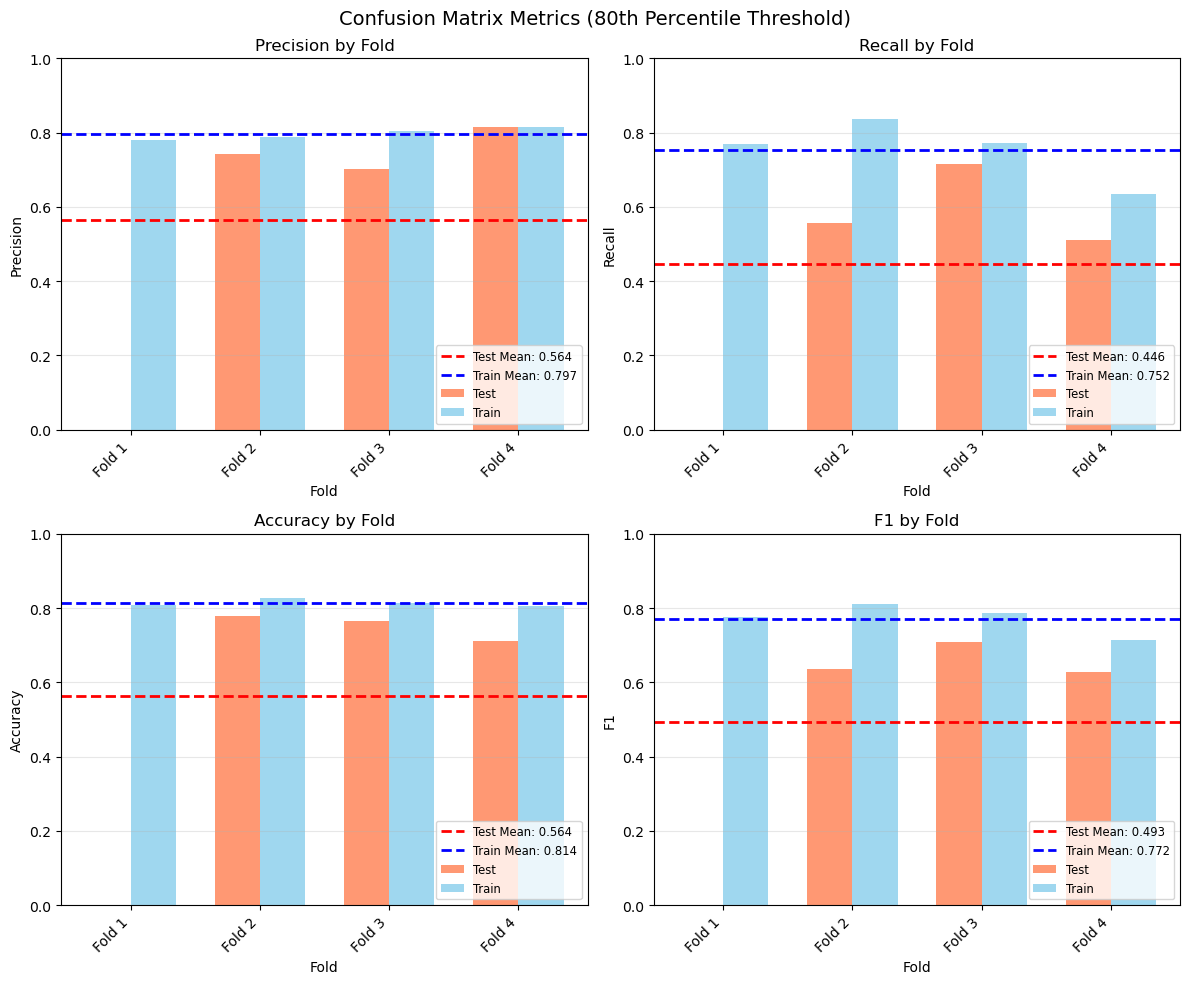

2026-01-16 12:02:33,142 INFO: Updated CV summary with confusion metrics saved to rnn_training/20260116_114638/cv_summary.json


In [34]:
# Compute confusion matrix metrics for CV results
from viz import compute_cv_confusion_metrics, plot_cv_confusion_summary, compute_roi_percentiles

# Set percentile threshold (e.g., 80th percentile means activity above this value is "active")
THRESHOLD_PERCENTILE = 80

# First, compute the thresholds to see what values they correspond to
roi_thresholds = compute_roi_percentiles(dfof, percentile=THRESHOLD_PERCENTILE, filter_neurons=FILTER_NEURONS)
print(f"\n{THRESHOLD_PERCENTILE}th percentile thresholds for target neurons:")
for roi in sorted(TARGET_NEURONS):
    if roi in roi_thresholds:
        print(f"  ROI {roi}: {roi_thresholds[roi]:.4f} df/F")

# Compute confusion metrics
cv_results, confusion_summary = compute_cv_confusion_metrics(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    good_pairs=good_pairs,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    percentile=THRESHOLD_PERCENTILE,
    save_dir=os.path.join(new_dir_path, 'confusion_metrics'),
)

# Plot confusion metrics summary
plot_cv_confusion_summary(
    cv_results=cv_results,
    summary=confusion_summary,
    save_path=os.path.join(new_dir_path, f'confusion_summary_p{THRESHOLD_PERCENTILE}.png'),
)

# Update CV summary with confusion metrics
cv_summary['confusion_summary'] = {
    'percentile': THRESHOLD_PERCENTILE,
    'test_precision': confusion_summary['test']['mean_precision'],
    'test_recall': confusion_summary['test']['mean_recall'],
    'test_accuracy': confusion_summary['test']['mean_accuracy'],
    'test_f1': confusion_summary['test']['mean_f1'],
    'train_precision': confusion_summary['train']['mean_precision'],
    'train_recall': confusion_summary['train']['mean_recall'],
    'train_accuracy': confusion_summary['train']['mean_accuracy'],
    'train_f1': confusion_summary['train']['mean_f1'],
}

# Save updated summary
with open(cv_summary_path, 'w') as f:
    json.dump(cv_summary, f, indent=2, default=str)
logging.info(f"Updated CV summary with confusion metrics saved to {cv_summary_path}")

Plotting CV raster for Config 3, ROI 26
Using 80th percentile threshold: 0.1150
2026-01-16 12:02:33,593 INFO: Saved CV raster to rnn_training/20260116_114638/rasters_cv/raster_cv_c3_roi26.png


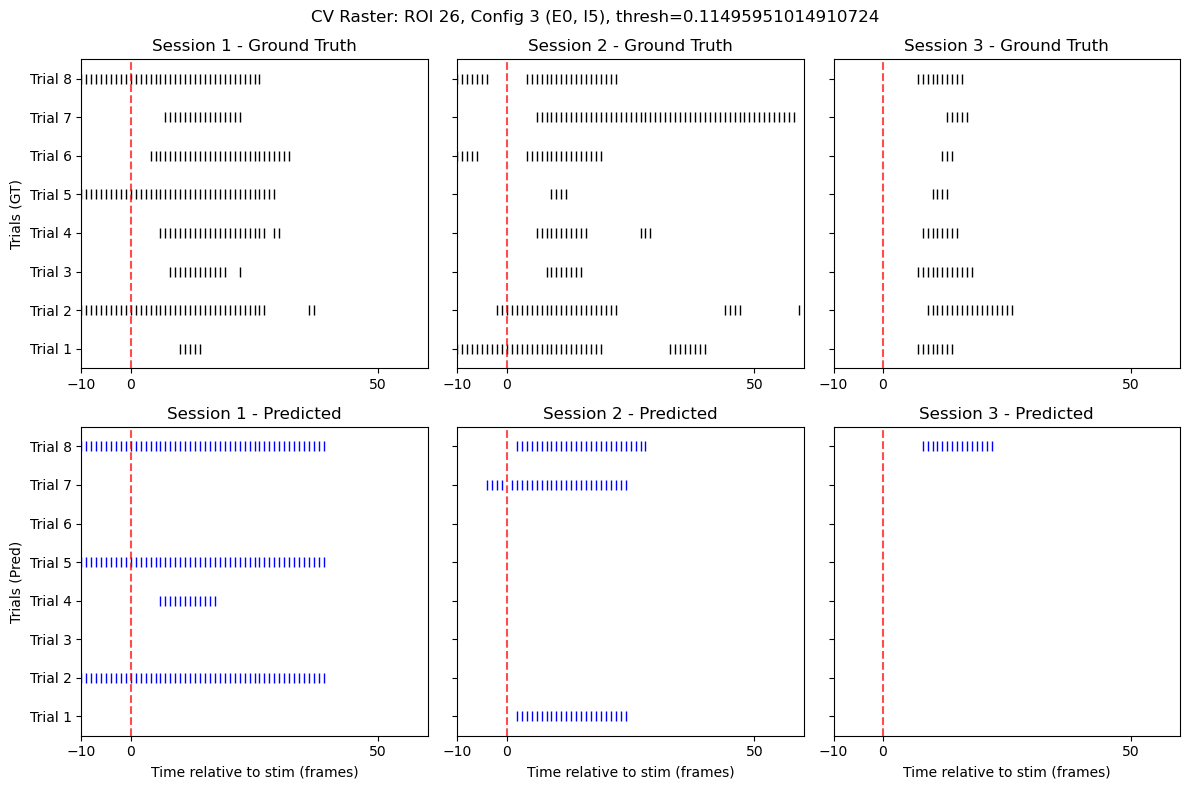

In [35]:
# Plot CV raster for a specific ROI and config
from viz import plot_stim_raster_cv

# Choose a (config, roi) pair from good_pairs to visualize
raster_config, raster_roi = good_pairs[0]  # e.g., (3, 26)

# Use the percentile threshold computed above
raster_threshold = roi_thresholds[raster_roi]

print(f"Plotting CV raster for Config {raster_config}, ROI {raster_roi}")
print(f"Using {THRESHOLD_PERCENTILE}th percentile threshold: {raster_threshold:.4f}")

os.makedirs(os.path.join(new_dir_path, 'rasters_cv'), exist_ok=True)

fig = plot_stim_raster_cv(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    neuron=raster_roi,
    config=raster_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    threshold=raster_threshold,
    pre_stim_frames=10,
    post_stim_frames=60,
    sessions=[0, 1, 2],
    save_path=os.path.join(new_dir_path, 'rasters_cv', f'raster_cv_c{raster_config}_roi{raster_roi}.png'),
)
plt.show()

## PSTHs like Yuxuans

In [36]:
from viz import plot_psth_from_cv_results


# Run the CV-based PSTH plotting
import pandas as pd
neurons_by_config = {}
for pair in good_pairs:
    if neurons_by_config.get(str(pair[0])) is None:
        neurons_by_config[str(pair[0])] = [pair[1]]
    else:
        neurons_by_config[str(pair[0])].append(pair[1])
default_neurons = TARGET_NEURONS  # Use all target neurons if no config-specific set



# Only plot neurons that are in TARGET_NEURONS (since model only predicts those)
# neurons_of_interest = [n for n in neurons_of_interest if n in TARGET_NEURONS]

plot_psth_from_cv_results(
    cv_results=cv_results,
    cv_hparams=CV_HPARAMS,
    valid_df=valid_df,
    dfof=dfof,
    configs_to_plot=configs_to_plot if 'configs_to_plot' in dir() else list(range(1, 32)),
    neurons_by_config=neurons_by_config,
    filter_neurons=FILTER_NEURONS,
    target_neurons=TARGET_NEURONS,
    device=device,
    model_dir=new_dir_path,
    input_size=input_size,
    output_size=output_size,
    initial_cond_size=initial_cond_size,
    snippet_length=SNIPPET_LENGTH,
    stim_delay=STIM_DELAY,
    post_stim_frames=50,
    subplot_size=2.5,
    show_ground_truth=True,
    line_alpha=0.9,
    pred_lw=1.2,
    gt_lw=2.0,
    n_sessions=3,
    save_dir=os.path.join(new_dir_path, 'psths_cv'),
)



2026-01-16 12:02:33,743 INFO: CV split strategy: current
2026-01-16 12:02:33,743 INFO: Holdout elements: [0, 3, 4, 5]
2026-01-16 12:02:33,745 INFO: Config 1: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-16 12:02:36,631 INFO: Saved CV PSTH: rnn_training/20260116_114638/psths_cv/config_1_cv.png
2026-01-16 12:02:36,632 INFO: Config 2: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-16 12:02:39,375 INFO: Saved CV PSTH: rnn_training/20260116_114638/psths_cv/config_2_cv.png
2026-01-16 12:02:39,376 INFO: Config 3: 24 snippets, neurons: [26, 22]
2026-01-16 12:02:40,135 INFO: Saved CV PSTH: rnn_training/20260116_114638/psths_cv/config_3_cv.png
2026-01-16 12:02:40,135 INFO: Config 4: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-16 12:02:42,975 INFO: Saved CV PSTH: rnn_training/20260116_114638/psths_cv/config_4_cv.png
2026-01-16 12:02:42,976 INFO: Config 5: 24 snippets, neurons: [21, 22, 23, 26, 27, 31]
2026-01-16 12:02:45,814 INFO: Saved CV PSTH: rnn_training/20260116_

## Loss over Epochs Plot

Plotting losses for Fold 1 (holdout=0)


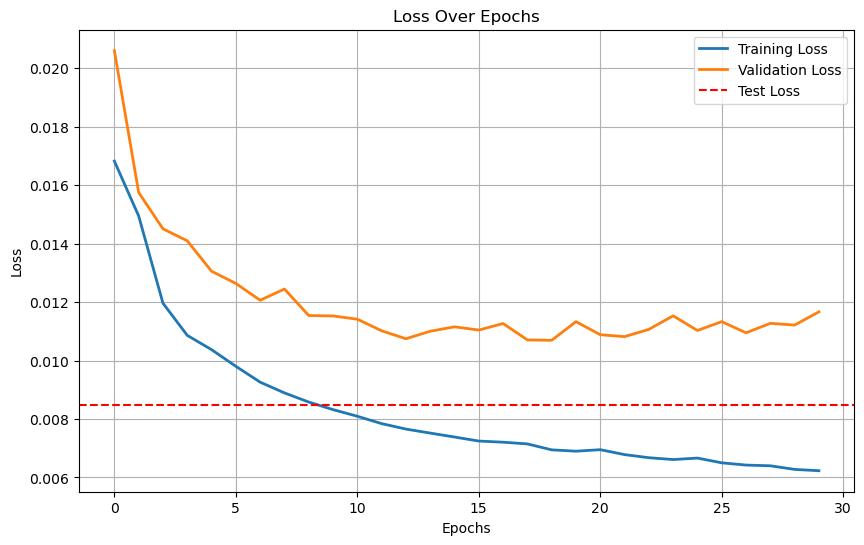

Plotting losses for Fold 2 (holdout=3)


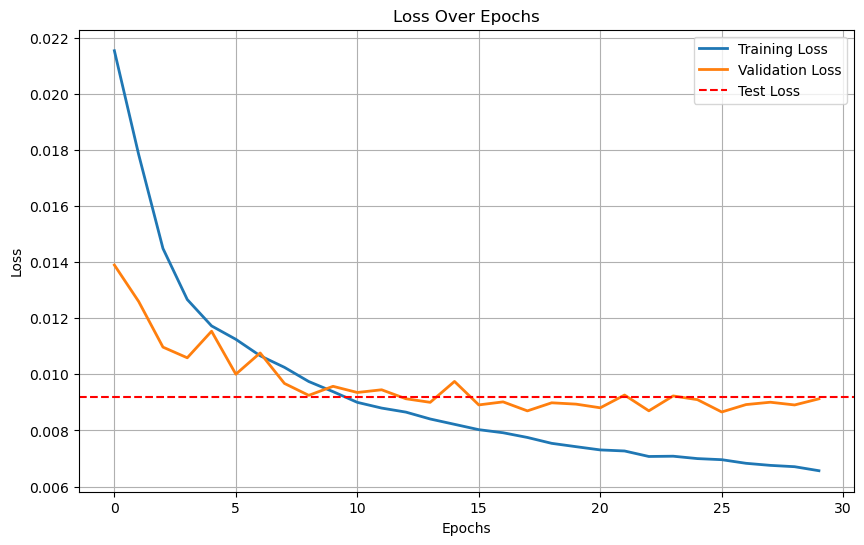

Plotting losses for Fold 3 (holdout=4)


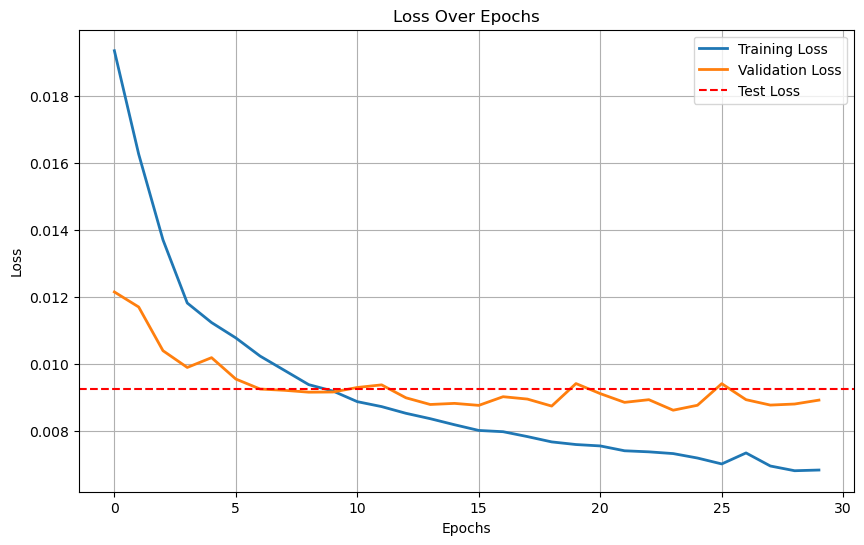

Plotting losses for Fold 4 (holdout=5)


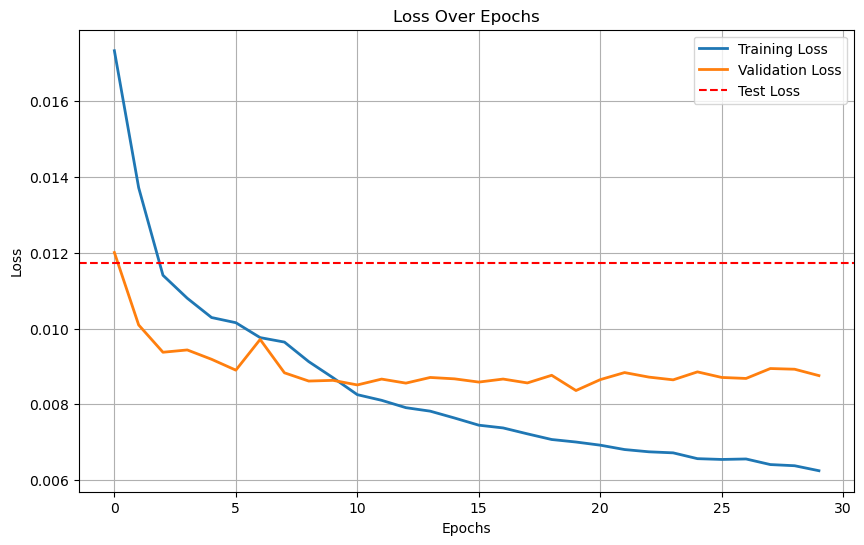


All CV loss plots saved to: rnn_training/20260116_114638/cv_losses


In [37]:
# Plot losses for each fold in cross-validation
from viz import plot_losses

# Create directory for CV loss plots
cv_losses_dir = os.path.join(new_dir_path, 'cv_losses')
os.makedirs(cv_losses_dir, exist_ok=True)

for r in cv_results:
    fold_idx = r['fold']
    holdout_elem = r['holdout_element']
    fold_history = r.get('history', None)
    fold_test_loss = r.get('test_loss', None)
    
    if fold_history is None:
        logging.warning(f"Fold {fold_idx}: No history found, skipping loss plot")
        continue
    
    # Create fold-specific save path
    fold_savepath = os.path.join(cv_losses_dir, f'fold_{fold_idx}_holdout_{holdout_elem}')
    os.makedirs(fold_savepath, exist_ok=True)
    
    print(f"Plotting losses for Fold {fold_idx} (holdout={holdout_elem})")
    plot_losses(fold_history, fold_test_loss, savepath=fold_savepath)

print(f"\nAll CV loss plots saved to: {cv_losses_dir}")

NameError: name 'HOLDOUT_TRIALS' is not defined

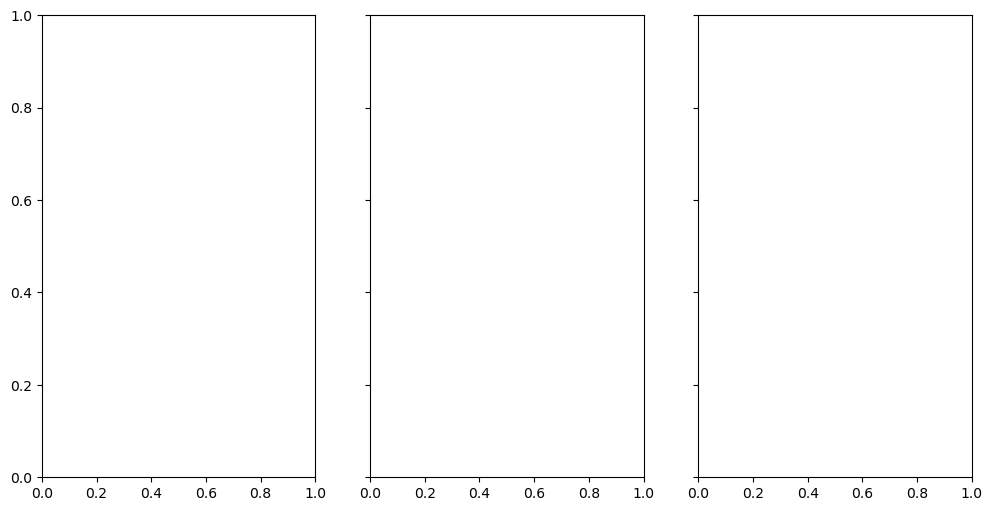

In [38]:
from viz import plot_stim_raster
# Example usage:
# plot_stim_raster(neuron=31, config=27, threshold=0.1)
if not os.path.exists(os.path.join(new_dir_path, "rasters")):
    os.makedirs(os.path.join(new_dir_path, "rasters"))
plot_stim_raster(trials_df, dfof, neuron=31, config=27, threshold=0.25, save_path=os.path.join(new_dir_path, "rasters", "n31_c28_t0.1.png"))

Generating: Config 3, Neuron 26, Threshold 0.1


NameError: name 'HOLDOUT_TRIALS' is not defined

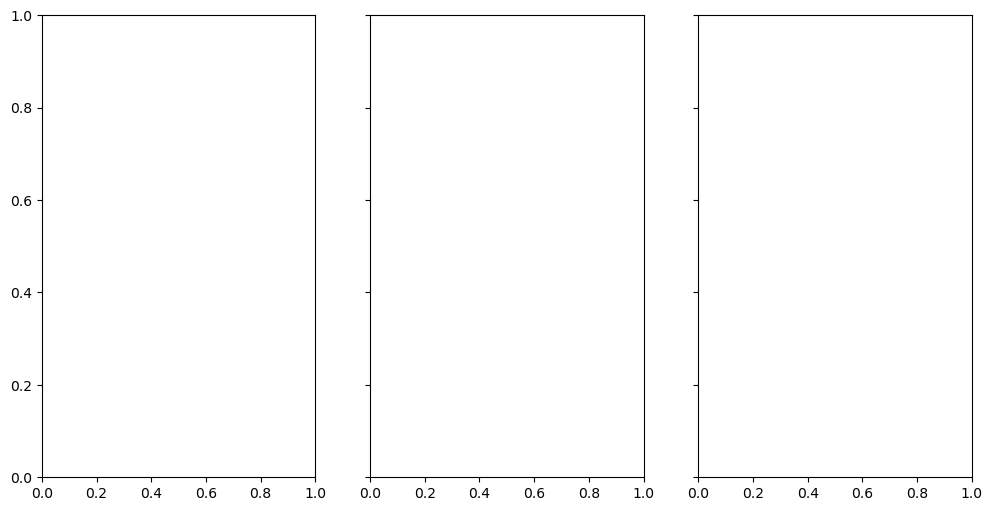

In [ ]:
# # Generate rasters for all good_pairs at multiple thresholds
# # good_pairs format: (config, neuron)
# thresholds = [0.1, 0.2, 0.3]

# # Create rasters directory
# rasters_dir = os.path.join(new_dir_path, "rasters")
# os.makedirs(rasters_dir, exist_ok=True)

# for config, neuron in good_pairs:
#     for thresh in thresholds:
#         save_name = f"raster_c{config}_n{neuron}_t{thresh}.png"
#         save_path = os.path.join(rasters_dir, save_name)
#         print(f"Generating: Config {config}, Neuron {neuron}, Threshold {thresh}")
#         plot_stim_raster(trials_df=trials_df, dfof=dfof, neuron=neuron, config=config, threshold=thresh, save_path=save_path)
#         plt.close()

# print(f"\nSaved {len(good_pairs) * len(thresholds)} raster plots to {rasters_dir}")

Config 1: Electrode 0, Current 3
Config 2: Electrode 0, Current 4
Config 3: Electrode 0, Current 5
Config 4: Electrode 1, Current 3
Config 5: Electrode 1, Current 4
Config 6: Electrode 1, Current 5
Config 7: Electrode 2, Current 3
Config 8: Electrode 2, Current 4
Config 9: Electrode 2, Current 5
Config 10: Electrode 3, Current 3
Config 11: Electrode 3, Current 4
Config 12: Electrode 3, Current 5
Config 13: Electrode 4, Current 3
Config 14: Electrode 4, Current 4
Config 15: Electrode 4, Current 5
Config 16: Electrode 5, Current 3
Config 17: Electrode 5, Current 4
Config 18: Electrode 5, Current 5
Config 19: Electrode 6, Current 3
Config 20: Electrode 6, Current 4
Config 21: Electrode 6, Current 5
Config 22: Electrode 7, Current 3
Config 23: Electrode 7, Current 4
Config 24: Electrode 7, Current 5
Config 25: Electrode 8, Current 3
Config 26: Electrode 8, Current 4
Config 27: Electrode 8, Current 5
Config 28: Electrode 9, Current 3
Config 29: Electrode 9, Current 4
Config 30: Electrode 9,

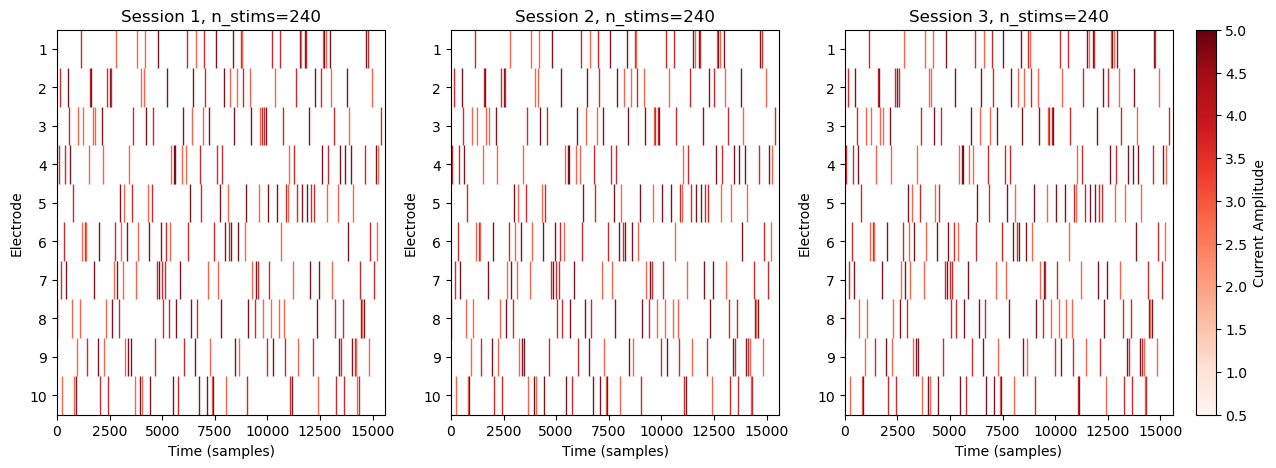

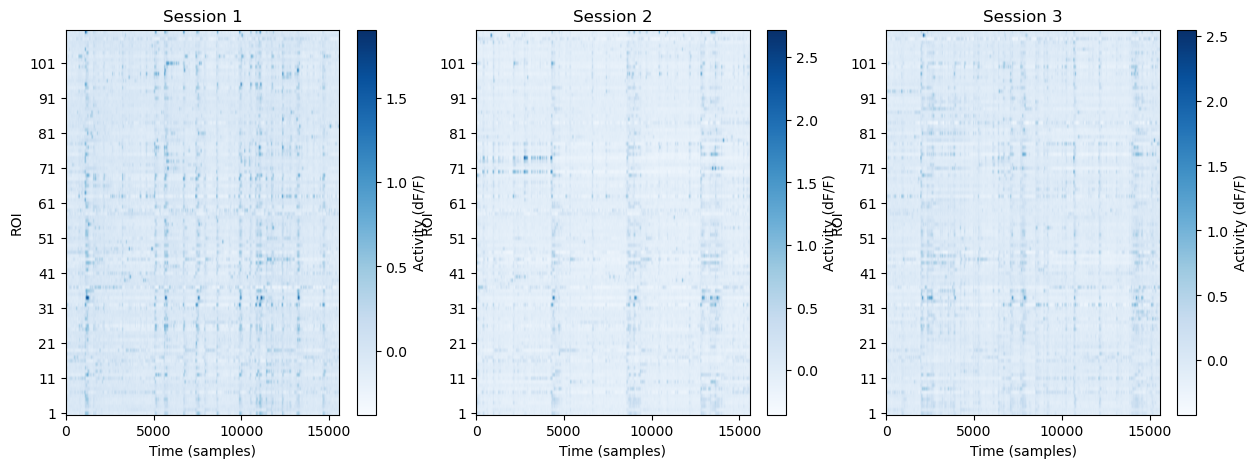

In [ ]:
from viz import plot_stim_ticks, plot_activity_per_session
stim_times_sess = []
for session in range(3):
    stim_times = np.zeros((dfof[session].shape[0], 10))
    for config in range(1, 31): # last config is no stim
        electrode = (config-1) // 3
        current = (config-1)%3 + 3
        print(f'Config {config}: Electrode {electrode}, Current {current}')
        for i in range(8):
            config_time = times[session][i,config-1]
            stim_times[config_time, electrode] = current
    stim_times_sess.append(stim_times) # len 3, each (n_times, n_electrodes)

stim_times_sess = np.array(stim_times_sess)
print ("Stim times sess shape: ", stim_times_sess.shape)

# how many frames have no stimulation?
n_no_stim = [stim_times_sess[i].shape[0] - np.count_nonzero(stim_times_sess[i]) for i in range(3)]
print (f'Number of no-stim frames per session: {",".join([str(n) for n in n_no_stim])} assuming 1 ms current pulse')




plot_stim_ticks(stim_times_sess, session_ids=None, tick_width=6, cmap_name='Reds',
                figsize=(15, 5), out_path=f'rnn_training/{DATETIME_STAMP}/stim_times_sessions_ticks.png',
                invert_y=True)

plot_activity_per_session(dfof, session_ids=None,
                          figsize=(15,5),
                          out_path=f'rnn_training/{DATETIME_STAMP}/activity_sessions.png')